# 1、数据预处理与数据集划分

主要负责数据的加载、清洗、特征转换以及最终的数据集划分。我们引入了自定义的数据处理管道模块，对原始的静态临床数据进行一系列预处理操作，并将其划分为训练集和测试集。

- 导入必要的库和自定义模块,包括用于删除常量列和二元化毒性等级的工具类。
- 读取静态数据 CSV 文件，并使用 ConstantColumnDropper 删除数值完全相同的列（即所有样本在该列上的值都一样，不具备区分度）。
- 使用 ToxicityBinarizer 将多个毒性指标（如 CRS、ICANS、Infection）根据阈值转换为二分类变量（例如：等级 > 2 视为严重，标记为 1；否则为 0）。
- 清洗目标变量列（Infection）中的缺失值，并重置索引以确保数据连续性。
- 使用 PatientLevelStratifiedSplitterWithCV 进行

基于患者层面的分层划分，生成训练集、测试集以及交叉验证折，确保同一患者的数据不会同时出现在训练集和测试集中，避免数据泄露。

### 关于字体BUGfindfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
参考：https://zhuanlan.zhihu.com/p/509574840

把windows下的Times New Roman字体上传到本地虚拟环境中的字体文件夹中
/opt/anaconda3/envs/pl/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/times.ttf
然后删除matplotlib的缓存
rm -rf /home/phl/.cache/matplotlib
最后重启vscode，重新运行代码

In [1]:
# 设置工作路径
import os
os.chdir("/home/phl/PHL/Car-T/model_v1")

# 获取并打印当前工作路径
current_path = os.getcwd()
print("当前工作路径：", current_path)

当前工作路径： /home/phl/PHL/Car-T/model_v1


In [2]:
# 导入Pandas库，用于数据处理
import pandas as pd

# 导入NumPy库，用于数值计算
import numpy as np

# 导入模型选择模块中的train_test_split，用于拆分数据集
from sklearn.model_selection import train_test_split

# 导入预处理模块中的StandardScaler 和OneHotEncoder，用于数据标准化和独热编码
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 导入逻辑回归模型
from sklearn.linear_model import LogisticRegression

# 导入随机森林分类器
from sklearn.ensemble import RandomForestClassifier

# 导入多层感知器分类器
from sklearn.neural_network import MLPClassifier

# 导入支持向量机分类器
from sklearn.svm import SVC

# 导入XGBoost库
# !pip install xgboost -i https://mirrors.aliyun.com/pypi/simple/
import xgboost as xgb

#导入LightGBM库
import lightgbm as lgb

In [3]:
import sys
import importlib

# 清除缓存并重新加载模块
if 'pipeline.perfect_pipeline' in sys.modules:
    importlib.reload(sys.modules['pipeline.perfect_pipeline'])

In [4]:
# 你需要确保下游的特征工程步骤（如读取动态数据）能够接受原始动态数据目录作为输入，而不是寻找 train_dynamic 文件夹。
# 要在特征提取或数据加载函数中，不要硬编码读取 ./train_dynamic/，代码实现如下：

def build_features_from_df(target_df, dynamic_source_dir):
    """
    target_df: 也就是 split 出来的 train_df 或 test_df
    dynamic_source_dir: 原始的 processed_standardized 文件夹路径
    """
    features = []
    # 只遍历当前分割 (train 或 test) 中的患者 ID
    for patient_id in target_df['ID']: 
        file_path = os.path.join(dynamic_source_dir, f"{patient_id}.csv")
        
        if os.path.exists(file_path):
            # 读取数据并处理
            df_dyn = pd.read_csv(file_path)
            # ... 特征工程逻辑 ...
        else:
            # 处理缺失情况
            pass
            
    return pd.DataFrame(features)


In [5]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm  # 用于显示进度条

def extract_baseline_features(patient_ids, dynamic_dir, time_col='Day', cutoff_day=0):
    """
    从动态文件中提取 Day < cutoff_day 的最后一次观测值作为静态基线特征。
    
    参数:
        patient_ids: 患者 ID 列表 (来自清洗好的数据 df_clean?['ID'])
        dynamic_dir: 动态数据文件夹路径
        time_col: 动态数据中表示时间的列名，默认为 'Day'
        cutoff_day: 截断时间点，默认为 0
        
    返回:
        pd.DataFrame: 包含提取特征的 DataFrame，索引为 ID
    """
    extracted_features = []
    
    print(f"正在从 {len(patient_ids)} 个动态文件中提取基线特征 (Day < {cutoff_day})...")
    
    for pid in tqdm(patient_ids):
        file_path = os.path.join(dynamic_dir, f"{pid}.csv")
        
        # 初始化字典，包含 ID
        patient_data = {'ID': pid}
        
        if os.path.exists(file_path):
            try:
                # 读取动态数据
                df_dyn = pd.read_csv(file_path)
                
                # 确保时间列存在且为数值型
                if time_col in df_dyn.columns:
                    # 1. 筛选：仅保留 Day < 0 的数据
                    # 注意：这里使用 < 0，不包含 Day 0。如果 Day 0 是输注前采集，可改为 <= 0
                    mask = df_dyn[time_col] < cutoff_day
                    df_baseline_window = df_dyn[mask]
                    
                    if not df_baseline_window.empty:
                        # 2. 排序：按时间升序排列
                        df_sorted = df_baseline_window.sort_values(by=time_col, ascending=True)
                        
                        # 3. 提取：取最后一行（即离 Day 0 最近的一次观测）
                        last_observation = df_sorted.iloc[-1]
                        
                        # 4. 转换：将 Series 转为字典，排除时间列
                        # 添加前缀 'baseline_' 以区分原始静态变量
                        for col in last_observation.index:
                            if col != time_col and col != 'ID': # 排除 ID 和 Day
                                patient_data[f"baseline_{col}"] = last_observation[col]
                                
                        # 特殊情况处理：记录最后一次观测具体是第几天（可选，用于质量控制）
                        # 含义：它表示提取的基线数据距离治疗开始（Day 0）有多少天。例如：如果一个患者在Day-1有数据，cutoff_day是0，那么gap=0-(-1)=1天。
                        # 如果一个患者最近一次检查是在 Day -20，那么 gap = 20 天。
                        # 作用：作为一个非常重要的特征，部分模型可能会利用这个信息，给近期数据更高的权重。
                        # 数据质量评估：Gap 越小（如 1-3 天），说明数据越能代表患者接受治疗前的即时状态。Gap很大（如>30天），说明数据可能已经“过期”，参考价值降低。
                        patient_data['baseline_gap_days'] = cutoff_day - last_observation[time_col]
            except Exception as e:
                print(f"处理 ID {pid} 时出错: {e}")
        
        extracted_features.append(patient_data)
    
    # 转换为 DataFrame
    df_features = pd.DataFrame(extracted_features)
    return df_features



In [6]:
# 数据集划分
# 参考：https://sklearn.apachecn.org/master/30/————3.1.2.2.2. 分层随机 Split（StratifiedShuffleSplit）
# 方案1:70/30 患者级分层划分；
# 方案2:70/30 患者级分层划分 + 5折交叉验证
from pipeline.perfect_pipeline import ConstantColumnDropper, ToxicityBinarizer
import pandas as pd
import numpy as np
from pipeline.data_splitters import (
    PatientLevelStratifiedSplitter,
    PatientLevelStratifiedSplitterWithCV,
    patient_level_train_test_split
)

# 读入静态数据和动态数据
df = pd.read_csv("/home/phl/PHL/Car-T/model_v1/B-NHL_reindexed_example/csv/B-NHL_static_data.csv")
dynamic_data_dir = "/home/phl/PHL/Car-T/model_v1/B-NHL_reindexed_example/processed"
print(f"原始分布: {df.shape}")
# print (df)

# =============================================================================
#  1. 行处理: 剔除 Ann Arbor分期（Ann Arbor stage即AAS） 为空的患者（即白血病或者原发中枢的患者） 
# 原理：后续读取动态数据时（如 build_features_from_df 函数），是基于 df['ID'] 列表进行遍历的。因此只需要在内存中的静态数据DataFrame即 df 里剔除这些患者对应的行。
# 这样，后续的程序逻辑自然就会跳过这些 ID，从而达到“逻辑删除数据”的效果，而不会在物理上删除磁盘上的原始动态数据文件。
# =============================================================================
print("=" * 70)
# 找出 AAS为 NaN 的行
if 'AAS' in df.columns:
    missing_AAS_mask = df['AAS'].isna()
    missing_ids = df.loc[missing_AAS_mask, 'ID'].values
    
    if len(missing_ids) > 0:
        print(f"步骤1(行处理): 发现 {len(missing_ids)} 例患者 AAS 信息缺失(即白血病或原发中枢患者), 患者ID: {missing_ids}, 正在执行剔除操作...")
        
        # 仅从静态数据 DataFrame 中剔除这些行, 只要这里剔除了 ID，后续步骤自然会跳过读取对应的动态数据文件。
        df_clean1 = df[~missing_AAS_mask].reset_index(drop=True)
        
        print(f"已剔除变量 AAS 为空的患者")
        print(f"处理后分布: {df_clean1.shape}")
    else:
        print("检查通过：未发现 AAS 为空的患者。")
else:
    print("警告：静态数据中未找到 'AAS' 列，跳过此检查。")
# print (df_clean1)

# =============================================================================
#  2. 行处理: 剔除目标变量为空的患者(仅逻辑剔除静态变量中的数据，不删除物理文件)
# =============================================================================
print("=" * 70)   
# 步骤1: 处理目标变量列中的缺失值
if 'Infection' in df.columns:

    # 找出目标变量为空的患者ID并打印
    missing_label_mask = df_clean1['Infection'].isna()
    if missing_label_mask.sum() > 0:
        missing_ids_infection = df_clean1.loc[missing_label_mask, 'ID'].values
        print(f"步骤2(行处理): 发现 {df_clean1['Infection'].isna().sum()} 例患者目标变量列 'Infection' 缺失, 患者ID: {missing_ids_infection}, 正在执行剔除操作...")

    # 删除目标变量列中包含 NaN 的行，会导致索引ID不连续，但是不影响后续数据划分
    # 分割器返回的是索引位置(iloc），不依赖原始索引值
    df_clean2 = df_clean1[df_clean1['Infection'].notna()].copy()
    print(f"目标变量分布: {df_clean2['Infection'].value_counts().to_dict()}")
    print(f"处理后分布: {df_clean2.shape}")

    # 可选：重置索引使其连续（推荐用于后续处理），虽然索引不连续不影响划分，但如果后续代码依赖连续索引，可能会出问题
    df_clean2 = df_clean2.reset_index(drop=True)
# print (df_clean2)

# # =============================================================================
# # 3. 行处理: 执行动态特征提取并合并
# # =============================================================================
# print("=" * 70)
# print("步骤3(行处理): 动态特征提取与合并")
# # 1. 提取特征, df_clean2 是当前清洗好的静态数据框
# baseline_features_df = extract_baseline_features(
#     patient_ids=df_clean2['ID'].values,
#     dynamic_dir=dynamic_data_dir, # 使用动态数据定义路径
#     time_col='day',               # 请确认动态CSV中时间列名为 'day' 还是 'time'
#     cutoff_day=0
# )

# # 2. 合并到主数据框
# # 使用左连接 (Left Join) 确保不会丢失 df_clean2 中的患者
# # 如果某个患者没有动态数据，新列将自动填充为 NaN
# print(f"\n合并前 df_clean2 形状: {df_clean2.shape}")
# df_clean3 = pd.merge(df_clean2, baseline_features_df, on='ID', how='left')
# print(f"合并后 df_clean3 形状: {df_clean3.shape}")

# # 3. 简单的缺失值检查
# new_cols = [c for c in df_clean3.columns if c.startswith('baseline_')]
# missing_counts = df_clean3[new_cols].isna().sum()
# print(f"\n新特征缺失值情况 (Top 5): \n{missing_counts.sort_values(ascending=False).head()}")
# print(f"处理后分布: {df_clean3.shape}")
# # print (df_clean3)

# =============================================================================
# 4. 值处理: 二元化毒性等级
# =============================================================================
print("=" * 70)
print("步骤4(值处理): 二元化毒性等级")
# 删除常量列 & 缺失值处理
# dropper = ConstantColumnDropper()
# df_clean4 = dropper.fit_transform(df_clean3)
# 检查缺失值并删除包含缺失值的行
#df_cleaned = df_cleaned.dropna()

# binarizer = ToxicityBinarizer(col="CRS", threshold=2)   # 单个指标二元化
binarizer = ToxicityBinarizer(      # 多个毒性指标使用相同阈值
    columns=["CRS", "ICANS", "E_ICAHT", "L_ICAHT", "Infection"],
    threshold=2)
# df_clean4 = binarizer.fit_transform(df_clean3)
df_clean4 = binarizer.fit_transform(df_clean2)

# =============================================================================
#  5. 列处理: 手动删除不需要的冗余列（仅删除静态变量中的部分列）
# =============================================================================
print("=" * 70)
# 根据需要修改冗余列列表
cols_to_drop = ['CCID', 'Disease']

if cols_to_drop:
    print(f"步骤5(列处理): 正在删除冗余列: {cols_to_drop}")
    df_clean5 = df_clean4.drop(columns=cols_to_drop, errors='ignore') # errors='ignore' 防止列不存在时报错
    print(f"处理后分布: {df_clean5.shape}")
# print (df_clean5)
df_final = df_clean5

# =============================================================================
# 4. 数据集划分，划分为70%训练集和30%测试集，使用基于类的分割器进行患者级分层分割
# =============================================================================
print("=" * 70)
print("步骤6(数据集划分): 基础患者级分层划分")

# a.基础分割器
# splitter = PatientLevelStratifiedSplitter(test_size=0.3, random_state=42)
# train_df, test_df = splitter.split(
#     df_final, 
#     label_col="Infection", 
#     patient_id_col="ID"  # 确保患者级独立性
# )
# print(f"\n训练集大小: {len(train_df)}")
# print(f"测试集大小: {len(test_df)}")

# b.带交叉验证的分割器（5折交叉验证）
# 注意：PatientLevelStratifiedSplitterWithCV 返回 3 个值：train_df, test_df, cv_folds
splitter = PatientLevelStratifiedSplitterWithCV(test_size=0.3, n_folds=5, random_state=42)    
train_df, test_df, cv_folds = splitter.split(
    df_final, 
    label_col="Infection", 
    patient_id_col="ID"  # 确保患者级独立性
)
print(f"\n训练集大小: {len(train_df)}")
print(f"测试集大小: {len(test_df)}")
print(f"交叉验证折数: {len(cv_folds)}")


原始分布: (13, 23)
步骤1(行处理): 发现 1 例患者 AAS 信息缺失(即白血病或原发中枢患者), 患者ID: [6], 正在执行剔除操作...
已剔除变量 AAS 为空的患者
处理后分布: (12, 23)
步骤2(行处理): 发现 2 例患者目标变量列 'Infection' 缺失, 患者ID: [ 5 13], 正在执行剔除操作...
目标变量分布: {0.0: 2, 3.0: 2, 2.0: 2, 4.0: 2, 5.0: 2}
处理后分布: (10, 23)
步骤4(值处理): 二元化毒性等级
[ToxicityBinarizer] 配置: 处理 5 个毒性指标
  [CRS] 阈值=2, 规则: ≤2 → 0 (非严重，包含2), >2 → 1 (严重)
    原始分布: {0: 3, 2: 3, 3: 2, 4: 2}
  [ICANS] 阈值=2, 规则: ≤2 → 0 (非严重，包含2), >2 → 1 (严重)
    原始分布: {0: 8, 4: 2}
  [E_ICAHT] 阈值=2, 规则: ≤2 → 0 (非严重，包含2), >2 → 1 (严重)
    原始分布: {1: 6, 2: 4}
  [L_ICAHT] 阈值=2, 规则: ≤2 → 0 (非严重，包含2), >2 → 1 (严重)
    原始分布: {0.0: 1, 2.0: 6, 3.0: 2}
  [Infection] 阈值=2, 规则: ≤2 → 0 (非严重，包含2), >2 → 1 (严重)
    原始分布: {0.0: 2, 2.0: 2, 3.0: 2, 4.0: 2, 5.0: 2}

[ToxicityBinarizer] 开始转换 5 个列...
  [CRS → CRS] 转换完成:
    0 (≤2级，非严重): 6 样本
    1 (>2级，严重): 4 样本
  [ICANS → ICANS] 转换完成:
    0 (≤2级，非严重): 8 样本
    1 (>2级，严重): 2 样本
  [E_ICAHT → E_ICAHT] 转换完成:
    0 (≤2级，非严重): 10 样本
    1 (>2级，严重): 0 样本
  [L_ICAHT → L_ICAHT] 转换完成:
    0 (≤2级，非严重):

In [7]:
# 2. 数据预览
print(f"\n数据预览:{df_final.shape}")
print(f"行数:{df_final.shape[0]}，列数:{df_final.shape[1]}")
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
#不换行显示
pd.set_option('display.expand_frame_repr', False)
# 显示处理后的数据框，head() 方法本身就只返回前5行数据
# print (df_final.head())
print(df_final)

# 查看训练集和测试集分布
print(f"\n训练集分布")
print(train_df)

print(f"\n测试集分布")
print(test_df)


数据预览:(10, 21)
行数:10，列数:21
   ID  Age     Sex   BMDB                    BMC   EM  EI B_symptoms     AAS  NL        PHSC  PCT   BT CTFA         CM      TYPE  CRS  ICANS  E_ICAHT  L_ICAHT  Infection
0   1   58    Male  57.00   Significantly_active   No   1         No  Stage4   1         NaN  Yes  Yes   No  41BB+CD28    Tandem    0      0        0        0          0
1   2   57    Male   0.00  Significantly_reduced   No   2         No  Stage1   3  Autologous  Yes   No   No       41BB    Single    0      0        0        0          0
2   3   46    Male  72.82       Extremely_active  Yes   2        Yes  Stage2   2  Allogeneic  Yes  Yes  Yes  41BB+CD28  Cocktail    0      0        0     <NA>          1
3   4   41    Male   0.11      Extremely_reduced  Yes   2        Yes  Stage3   4  Autologous  Yes   No   No  41BB+CD28    Tandem    0      0        0        0          1
4   7   42  Female   7.25  Significantly_reduced   No   2        Yes  Stage3   4  Autologous   No   No   No       41BB  Coc

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # 导入缺失值填充器

# 分离特征和目标变量
X_train = train_df.drop(columns=['Infection', 'ID'])  # 特征
y_train = train_df['Infection']                 # 目标变量

X_test = test_df.drop(columns=['Infection', 'ID'])  # 特征
y_test = test_df['Infection']  

# X = df[['area', 'rooms', 'floor', 'year_built', 'location']] 
# y = df['price']

# print("\n特征数据预览:")
# print(X_train.head())
# print("\n目标变量数据预览:")
# print(y_train.head())

# # 构建预处理步骤--方法一
# # 将分类变量转换为独热编码
# categorical_cols = ['X66', 'X77']
# encoder = OneHotEncoder(drop='first', sparse_output=False)
# X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))
# X = pd.concat([X.drop(columns=categorical_cols), X_encoded], axis=1)

# # 标准化数值特征
# val_cols = ['X1', 'X2', 'X3', 'X4', 'X5']
# scaler = StandardScaler()
# X[val_cols] = scaler.fit_transform(X[val_cols])

# # 将数据转换为 fLoat32 类型
# X = X.astype(np.float32)

# 构建预处理步骤--方法二
# 1. 使用您数据中真实的列名
numeric_features = ['Age', 'BMDB',]                                                                          # 数值型特征
# categorical_features_2 = ['Sex', 'EM', 'B_symptoms', 'BT', 'CTFA', 'CRS', 'ICANS', 'E_ICAHT', 'L_ICAHT']   # 类别型特征
categorical_features = ['BMC', 'EI', 'AAS', 'NL', 'PHSC', 'CM', 'TYPE',
                        'Sex', 'EM', 'B_symptoms', 'BT', 'CTFA', 'PCT', 'CRS', 'ICANS', 'E_ICAHT', 'L_ICAHT']
# 2. 定义转换器
# 类别型特征的预处理
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # 用中位数填充缺失值
    ('scaler', StandardScaler())  # 数值特征标准化
])

# 类别型特征的预处理
categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # 用常数'missing'填充缺失值
    # drop='first' 适合线性模型(逻辑回归)，handle_unknown=PCgnore' 适合树模型
    # 如果主要用 XGBoost/RF，建议去掉 drop='first'，保留 handle_unknown='ignore'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))   # 处理测试集中的新类别
])

# 3. 组合成 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # 重要：保留未在上面列出的其他列，否则会被丢弃
)

# 4. 应用 (注意：要在拆分训练/测试集之后 fit)
# 假设您已经有了 X_train, X_test

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# 5. (可选) 如果想看列名，可以将结果转回 DataFrame
feature_names_train = (numeric_features + 
                 list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)) + 
                 [col for col in X_train.columns if col not in numeric_features + categorical_features])
X_train = pd.DataFrame(X_train_transformed, columns=feature_names_train)

feature_names_test = (numeric_features + 
                 list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)) + 
                 [col for col in X_test.columns if col not in numeric_features + categorical_features])
X_test = pd.DataFrame(X_test_transformed, columns=feature_names_test)


# ===================================
# === 增强版修复代码（针对本地数据缺失值过多）：强制数值转换 + 多重填充策略 ===

# 输入数据中包含缺失值 (NaN)，而 Scikit-Learn 的模型（如 SVM、逻辑回归、MLP、随机森林）不支持缺失值。

# 具体原因分析
# 在前面的步骤（单元格 9）中，静态数据与动态数据合并时使用了 how='left'。代码输出显示 新特征缺失值情况，说明 baseline_ 开头的动态特征列中存在大量 NaN（因为部分患者没有动态数据）。

# 预处理未覆盖：
# 在单元格 11 中，你定义了 numeric_transformer 来填充 numeric_features 中的缺失值。但是，对于 baseline_ 等动态特征，你使用了 remainder='passthrough'。这意味着这些列原样保留，其中的 NaN 并没有被填充。

# 导致的问题：
# SVM、逻辑回归、MLP、随机森林：这些 Scikit-Learn 模型无法处理 NaN，会直接报错 ValueError: Input contains NaN, infinity or a value too large for dtype('float64')。
# XGBoost、LightGBM：这些模型可以自动处理 NaN，但代码在运行到它们之前就已经在 SVM 处崩溃了。
# 需要处理那些“passthrough”列的缺失值。最简单的方法是在数据进入 ColumnTransformer 之前，或者在生成 X_train 后立即填充缺失值。

# 常见填充策略：
# 中位数填充：对于数值型列，使用该列的中位数填充缺失值。
# 众数填充：对于类别型列，使用该列的众数填充缺失值。
# 常数填充：对于某些列，可以使用固定值（如 0 或 'missing'）填充缺失值。

# 以下是增强版的缺失值填充代码，专门处理那些未经过预处理器的列，确保所有列都没有缺失值，防止模型报错。
# 通常是因为 某些列（特别是 baseline_ 开头的动态特征）可能整列都是缺失值（NaN），或者包含非数值型数据（如字符串）。

# 如果某列全是 NaN，median() 计算结果也是 NaN，导致 fillna 无效，SVM 等模型依然会报错。
# 如果 passthrough 保留了非数值列，模型也会报错。
# 请使用下面的增强版修复代码替换原来的修复部分。它会强制将数据转为数值型，并对全空的列填充 0。

# 1. 强制转换为数值类型 (将可能混入的字符串/Object类型转为NaN，防止模型报错)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# 2. 计算训练集的中位数
train_medians = X_train.median()

# 3. 填充缺失值：
# 第一步：用中位数填充
# 第二步：如果中位数也是NaN (说明整列都是NaN)，则填 0 (代表无数据)
X_train = X_train.fillna(train_medians).fillna(0)
X_test = X_test.fillna(train_medians).fillna(0)

# 4. 最终检查 (打印剩余 NaN 数量，应为 0)
print(f"预处理后 X_train 缺失值数量: {X_train.isna().sum().sum()}")
print(f"预处理后 X_test 缺失值数量: {X_test.isna().sum().sum()}")
# ===================================


# # 查看数据预处理后的结构
# print("预处理后的训练数据：")
# print(X_train)
# print("预处理后的测试数据：")
# print(X_test)



预处理后 X_train 缺失值数量: 0
预处理后 X_test 缺失值数量: 0


In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# 代码参考：https://www.bilibili.com/video/BV1j2421Z7ti?spm_id_from=333.788.player.switch&vd_source=fe18fc7331f8146ed53da453b38c3226


# # 分割数据集
# # 分割数据集为训练集和测试集，测试集占20%
# X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# # 再次分割训练集以获取验证集，验证集占训练集的25%，即0.25 × 0.8 = 0.2
# X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.25,random_state=42)


# 构建SVM模型
svm = SVC(probability=True, random_state=42)
svm.fit(X_train,y_train)


# 构建XGBoost模型
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    use_label_encoder=False, 
    learning_rate=0.1, 
    max_depth=5, 
    n_estimators=100, 
    random_state=42)
xgb_model.fit(X_train,y_train)

# 构建GBM模型
params ={
    'objective':'binary',
    'metric':'binary_logloss',
    'boosting_type':'gbdt',
    'learning_rate': 0.1,
    'num_leaves':31,
    'max_depth':-1,
    'min_data_in_leaf':20,
    'num_threads': 4,
    'verbose':-1}
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(params,lgb_train, num_boost_round=109)


# 构建逻辑回归模型
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train)

# 构建随机森林模型
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train,y_train)

# 构建多层感知器（MLP）模型
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train,y_train)

/opt/anaconda3/envs/pl/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [10:40:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,hidden_layer_sizes,"(100,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


特征重要性图已保存至: /home/phl/PHL/Car-T/model_v1/output/rf_feature_importance.pdf


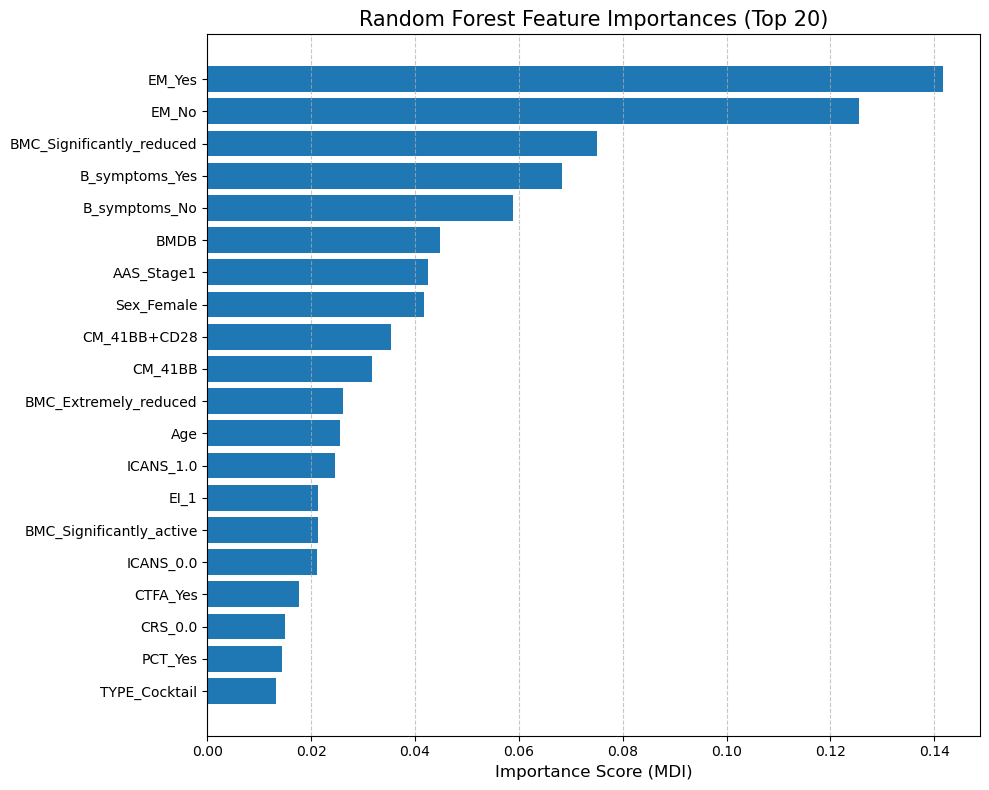


Top 10 Feature Importances:
                  feature  importance
                   EM_Yes    0.141709
                    EM_No    0.125439
BMC_Significantly_reduced    0.075099
           B_symptoms_Yes    0.068367
            B_symptoms_No    0.058929
                     BMDB    0.044785
               AAS_Stage1    0.042517
               Sex_Female    0.041808
             CM_41BB+CD28    0.035374
                  CM_41BB    0.031803


In [10]:
# 基于您当前项目的实际代码结构（单元格 11 已完成预处理并生成了带列名的 X_train DataFrame，单元格 12 单独训练了 rf 模型），实现方式比单元格 13 的官方示例要简单得多。

# 主要区别：
# 官方示例 (Cell 13)：使用了 Pipeline 包含预处理和模型，所以需要深入 named_steps 去挖掘特征名称。
# 您的项目：预处理和训练是分开的。X_train 已经是包含所有特征名称的 DataFrame，rf 是独立的分类器。

# 随机森林特征重要性排序
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# 1. 获取特征重要性和特征名称
# 您的 rf 模型是在 Cell 12 中单独定义的，不是 Pipeline
# 您的 X_train 在 Cell 11 中已经处理为带有列名的 DataFrame，可以直接使用
importances = rf.feature_importances_
feature_names = X_train.columns

# 2. 数据整合与排序
# 创建一个 DataFrame 方便处理
feature_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# 按重要性降序排序
feature_imp_df = feature_imp_df.sort_values(by='importance', ascending=False)

# 3. 绘图配置
# 考虑到 OneHot 编码后特征可能很多，我们只展示 Top 20
top_n = 20
top_features = feature_imp_df.head(top_n)

# 为了让 barh 图中最重要的特征显示在最上方，绘图数据需要反转顺序（升序）
plot_data = top_features.sort_values(by='importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
y_ticks = np.arange(len(plot_data))

# 绘制水平条形图
ax.barh(y_ticks, plot_data['importance'], color='#1f77b4')
ax.set_yticks(y_ticks)
ax.set_yticklabels(plot_data['feature'])

ax.set_title(f"Random Forest Feature Importances (Top {top_n})", fontsize=15)
ax.set_xlabel("Importance Score (MDI)", fontsize=12)

# 添加网格线方便阅读
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

# 保存图片
output = "/home/phl/PHL/Car-T/model_v1/output"
output_path = os.path.join(output, "rf_feature_importance.pdf")
if not os.path.exists(output):
    os.makedirs(output)
    
plt.savefig(output_path)
print(f"特征重要性图已保存至: {output_path}")
plt.show()
print("\nTop 10 Feature Importances:")      # 打印 Top 10 特征的具体数值
print(feature_imp_df.head(10).to_string(index=False))

# 多重共线性分析 (基于 Spearman 相关性与层次聚类)

本部分基于参考笔记本的第15个单元格，使用 Spearman 相关性和层次聚类来分析当前项目数据的多重共线性。

/opt/anaconda3/envs/pl/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/pl/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


树状图已保存至: /home/phl/PHL/Car-T/model_v1/output/feature_clustering_dendrogram.pdf


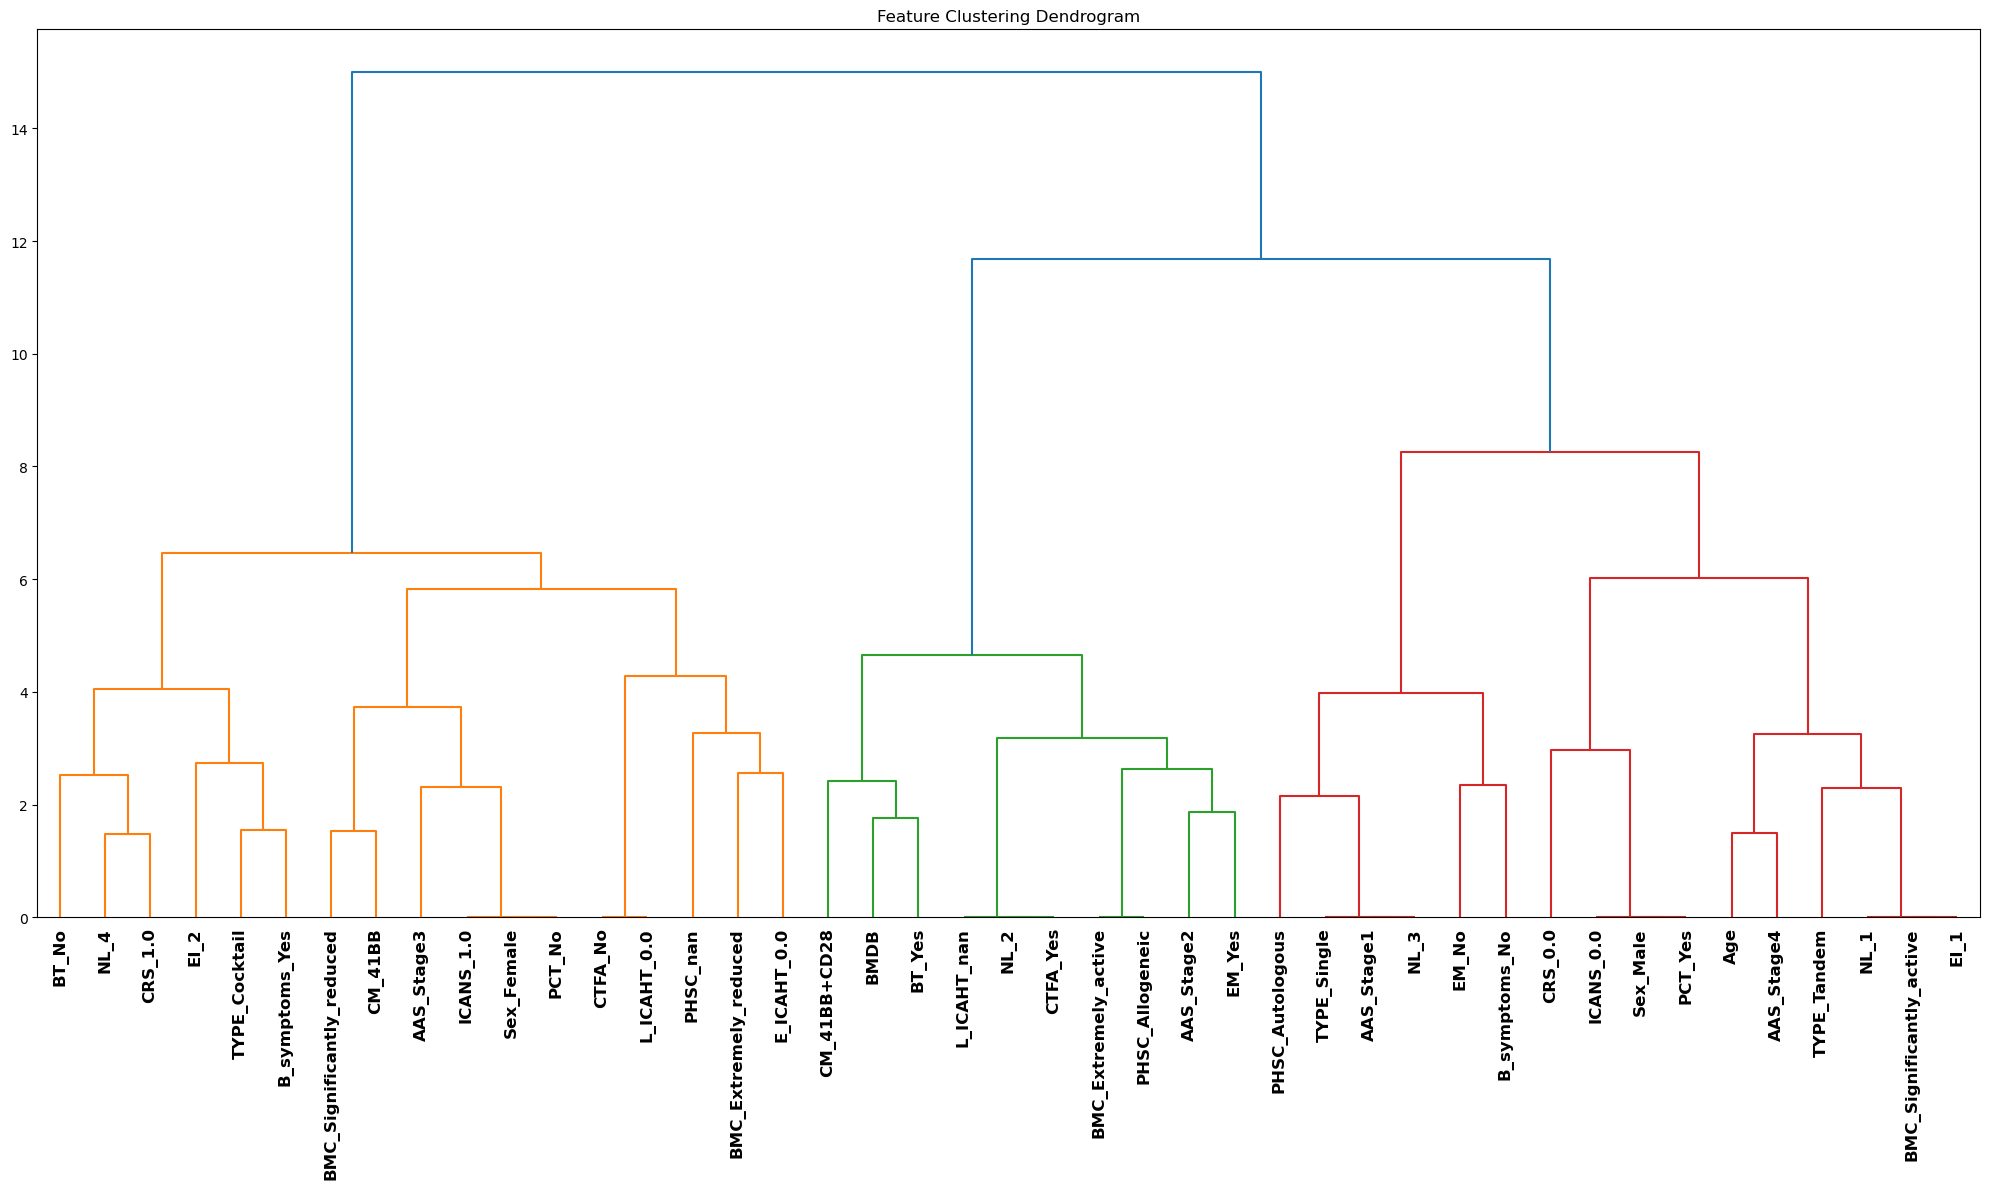

/tmp/ipykernel_135744/2295588829.py:74: UserWarning: Adding colorbar to a different Figure <Figure size 2000x1600 with 2 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=ax2)


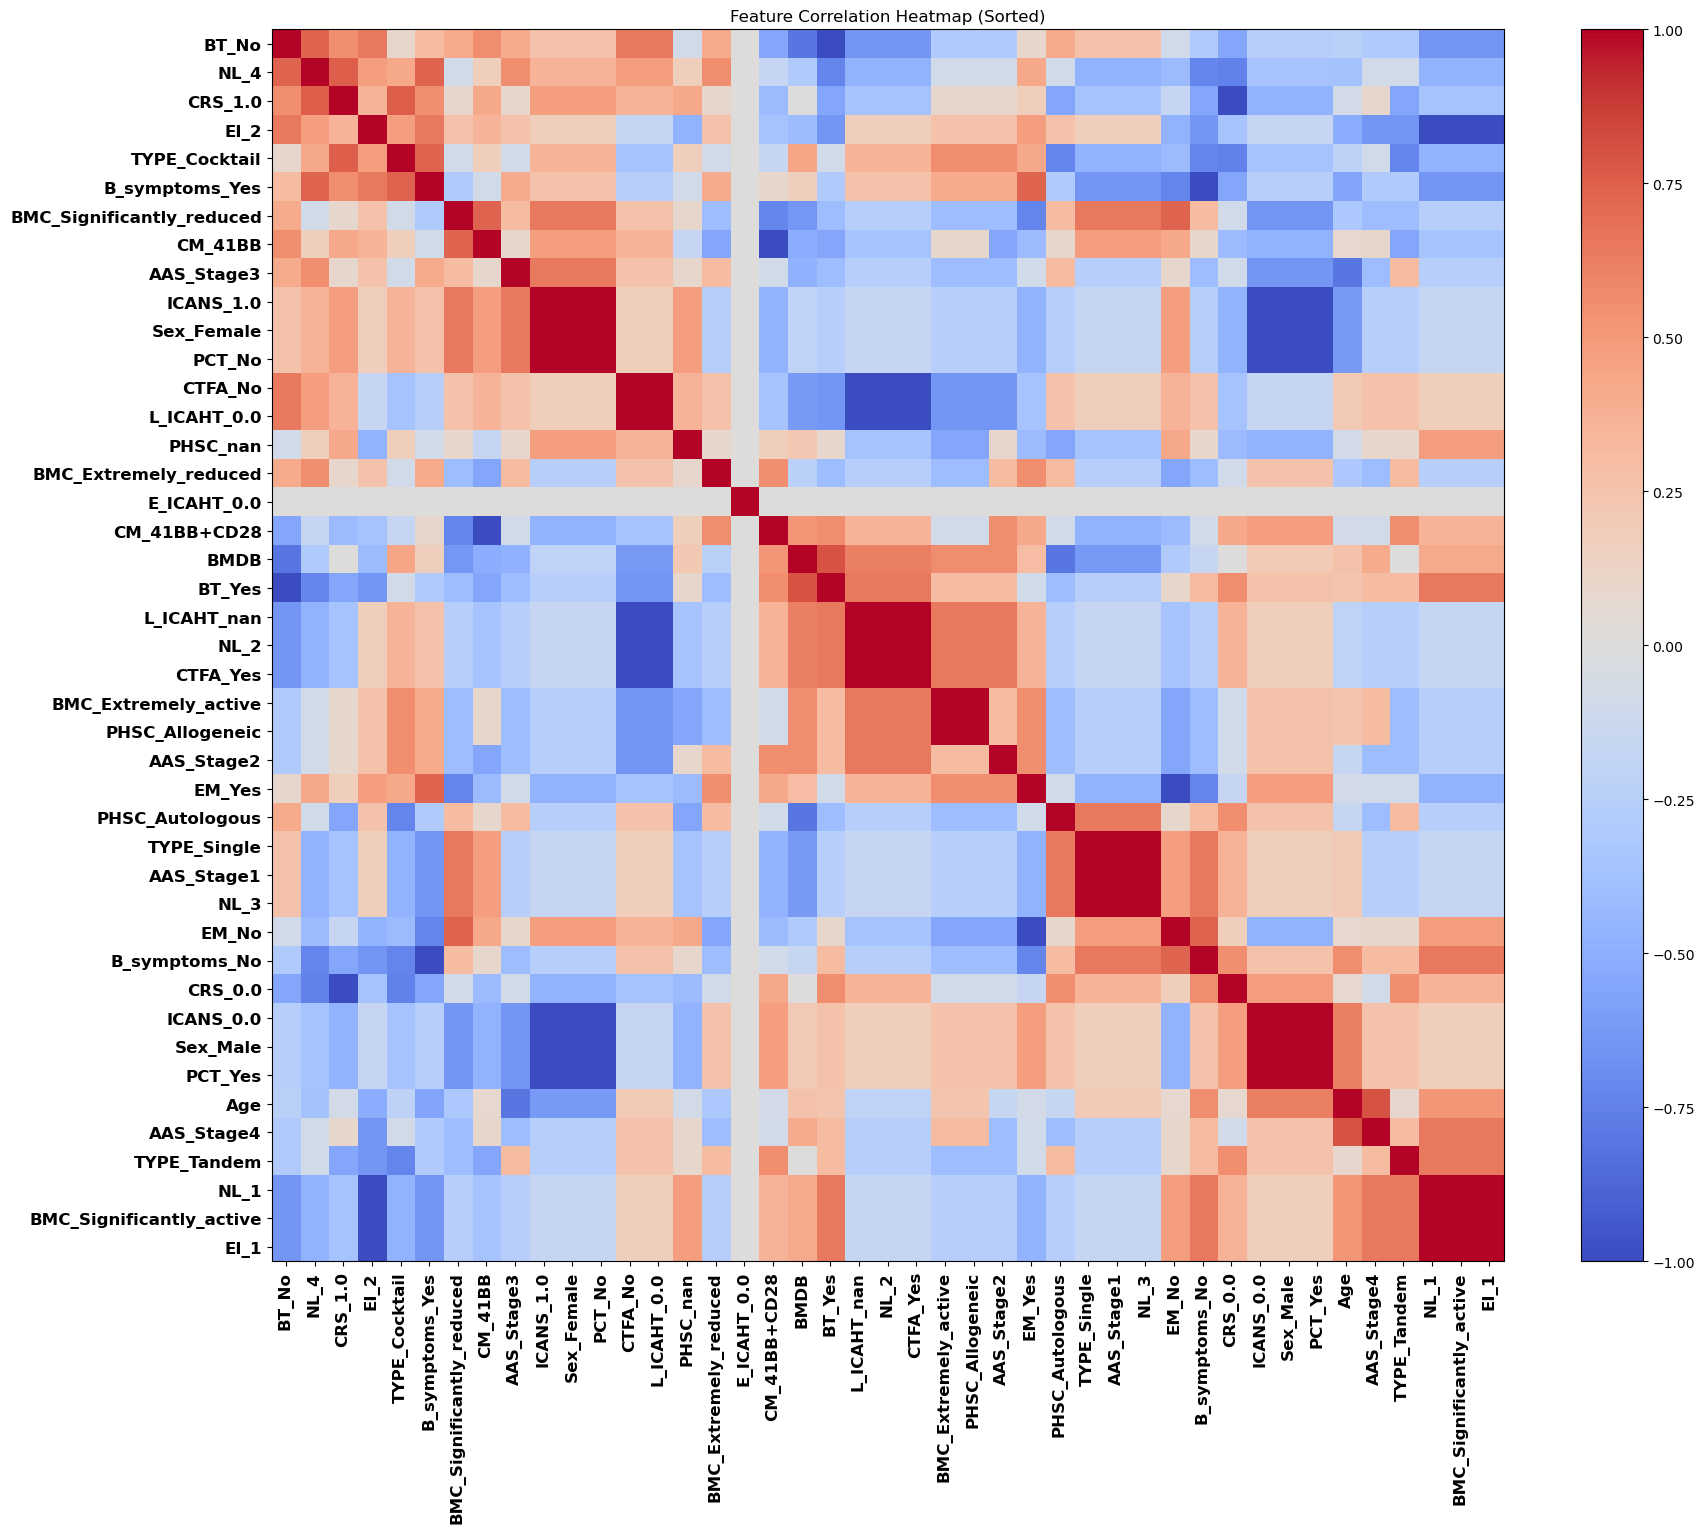

In [11]:
# 导入必要的统计和聚类库
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import numpy as np

# 计算 Spearman 相关性矩阵
# 使用训练集 X_train 进行计算
# spearmanr 返回值的属性是 statistic，或者它是一个元组(旧版本)
res = spearmanr(X_train)
if hasattr(res, 'statistic'):
    corr = res.statistic
else:
    corr = res[0]

# 处理可能出现的 NaN 值（常量列会导致相关性为 NaN，进而导致 hierarchy.ward 报错）
# 将 NaN 替换为 0（表示无相关性）
corr = np.nan_to_num(corr)

# 确保相关性矩阵是对称的（处理可能的数值误差）
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# 执行层次聚类 (Ward Linkage)
# 将相关性矩阵转换为距离矩阵进行聚类处理
# hierarchy.ward 期望输入是压缩的距离矩阵或原始观测值，这里直接对相关性矩阵操作
corr_linkage = hierarchy.ward(corr)

# 绘制树状图和相关性热图
fig_tree, ax1 = plt.subplots(figsize=(20, 12))           # 创建独立的画布用于树状图
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))   # 创建一个画布，包含两个子图

# 绘制树状图
dendro = hierarchy.dendrogram(
    corr_linkage, 
    labels=X_train.columns, 
    ax=ax1,
    leaf_rotation=90,
    leaf_font_size=12   # 设置字号
)

# 调整树状图标签字体样式
# 遍历 x 轴标签，设置为加粗和纯黑色
for label in ax1.get_xticklabels():
    label.set_fontweight('bold')
    label.set_color('black')
ax1.set_title("Feature Clustering Dendrogram")
plt.tight_layout()

# 保存树状图
tree_output_path = "/home/phl/PHL/Car-T/model_v1/output/feature_clustering_dendrogram.pdf"
plt.savefig(tree_output_path)
print(f"树状图已保存至: {tree_output_path}")
plt.show()


# 2. 单独绘制并保存重排后的相关性热图
fig_heat, ax2 = plt.subplots(figsize=(20, 16))  # 创建独立的画布用于热图
label_fontsize = 12  # 定义标签字号大小

# 使用 dendro['leaves'] 来重新排序相关性矩阵，使其与树状图对齐
# cmap='coolwarm': 蓝红配色 (蓝色负相关, 红色正相关)；camp='viridis': 绿色渐变
# vmin=-1, vmax=1: 确保颜色映射范围覆盖 -1 到 1
dendro_idx = np.arange(0, len(dendro['ivl']))   # 获取聚类后的索引顺序
im = ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']], cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)

# 应用字号设置，并加粗字体、设置为纯黑色以提高清晰度
ax2.set_xticklabels(dendro['ivl'], rotation='vertical', fontsize=label_fontsize, color='black', fontweight='bold')
ax2.set_yticklabels(dendro['ivl'], fontsize=label_fontsize, color='black', fontweight='bold')
ax2.set_title("Feature Correlation Heatmap (Sorted)")

fig.colorbar(im, ax=ax2)
fig.tight_layout()

# 保存图像
plt.savefig("/home/phl/PHL/Car-T/model_v1/output/feature_collinearity_spearman.pdf")
plt.show()

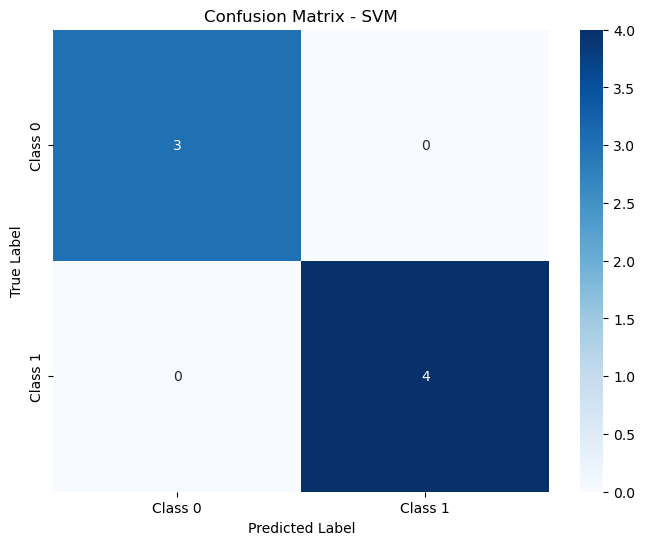

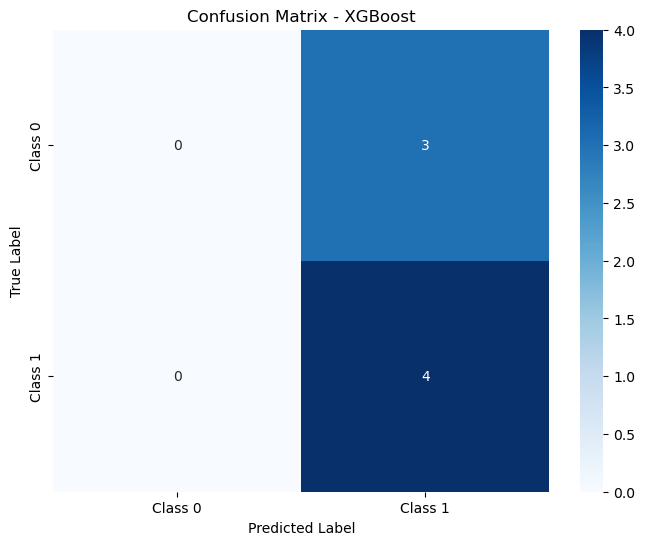

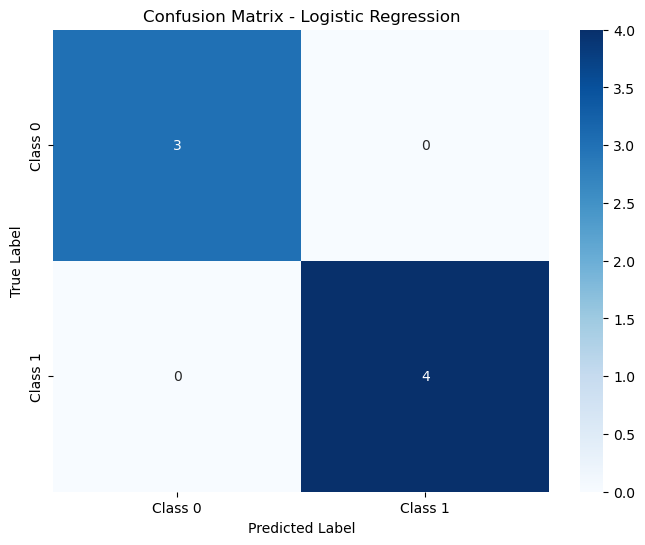

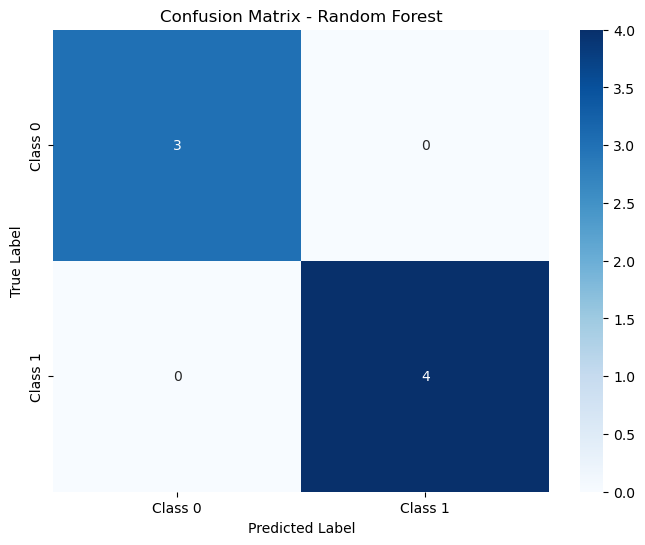

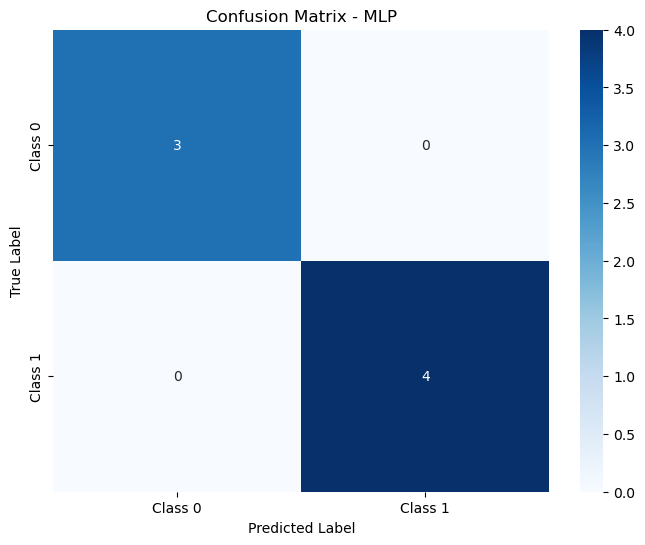


Model performance metrics (Train Set)
                       AUC  Accuracy  Precision  Recall  F1_score
Model                                                            
SVM                 0.0000    1.0000     1.0000  1.0000    1.0000
XGBoost             0.5000    0.5714     0.5714  1.0000    0.7273
Logistic Regression 1.0000    1.0000     1.0000  1.0000    1.0000
Random Forest       1.0000    1.0000     1.0000  1.0000    1.0000
MLP                 1.0000    1.0000     1.0000  1.0000    1.0000

 指标表格已保存到: /home/phl/PHL/Car-T/model_v1/output/model_metrics_summary_train.csv

详细混淆矩阵

SVM:
  TN=3, FP=0
  FN=0, TP=4
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000

XGBoost:
  TN=0, FP=3
  FN=0, TP=4
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 0.0000

Logistic Regression:
  TN=3, FP=0
  FN=0, TP=4
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000

Random Forest:
  TN=3, FP=0
  FN=0, TP=4
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000

MLP:
  TN=3, FP=0
  FN=0, TP

In [12]:
# 参考：https://mp.weixin.qq.com/s/WyLyVmWmiWCwjfStkeVobA
# 计算训练集各类模型评估指标

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

def calculate_metrics(model, X, y, label, is_lgb=False):
    """仅计算指标，返回字典"""
    if is_lgb:
        y_pred_proba = model.predict(X, num_iteration=model.best_iteration)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
        
    y_pred_label = model.predict(X)     # 预测测试集的类别
    
    metrics = {
        'Model': label,                                         # 添加模型名称
        'AUC': roc_auc_score(y, y_pred_proba),                  # 计算AUC
        'Accuracy': accuracy_score(y, y_pred_label),            # 计算准确率
        'Precision': precision_score(y, y_pred_label, zero_division = "warn"),          # 计算精确率
        'Recall': recall_score(y, y_pred_label, zero_division = "warn"),                # 计算召回
        'F1_score': f1_score(y, y_pred_label, zero_division = "warn"),                        # 计算F1分数
        'Confusion_Matrix': confusion_matrix(y, y_pred_label),  # 计算混淆矩阵

    }
    
    # print(f"\n{label} 指标:")
    # print(f"  AUC: {metrics['auc']:.2f}")
    # print(f"  Accuracy: {metrics['accuracy']:.2f}")
    # print(f"  Precision: {metrics['precision']:.2f}")
    # print(f"  Recall: {metrics['recall']:.2f}")
    # print(f"  F1 Score: {metrics['f1']:.2f}")
    # print(f"  Confusion Matrix:\n{metrics['confusion_matrix']}")

    
    return metrics

def plot_confusion_matrix(cm, label, subdir="confusion_matrix_train"):
    """绘制混淆矩阵"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {label}')
    
    # 确保目录存在
    output_dir = os.path.join("/home/phl/PHL/Car-T/model_v1/output", subdir)
    os.makedirs(output_dir, exist_ok=True)
    
    # 处理文件名中的空格
    safe_label = label.replace(' ', '_')
    filepath = os.path.join(output_dir, f"confusion_matrix_{safe_label}.pdf")
    
    plt.savefig(filepath, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()  # 关闭图形,避免内存占用
    
# ========== 计算各模型指标并绘制混淆矩阵 ==========
all_metrics_train = []

# SVM
metrics_train = calculate_metrics(svm, X_train, y_train, label='SVM')
all_metrics_train.append(metrics_train)
plot_confusion_matrix(metrics_train['Confusion_Matrix'], 'SVM')

# XGBoost
metrics_train = calculate_metrics(xgb_model, X_train, y_train, label='XGBoost')
all_metrics_train.append(metrics_train)
plot_confusion_matrix(metrics_train['Confusion_Matrix'], 'XGBoost')

# LightGBM (如果需要)
# metrics_train = calculate_metrics(lgb_model, X_train, y_train, label='LightGBM', is_lgb=True)
# all_metrics_train.append(metrics_train)
# plot_confusion_matrix(metrics_train['Confusion_Matrix'], 'LightGBM')

# Logistic Regression
metrics_train = calculate_metrics(log_reg, X_train, y_train, label='Logistic Regression')
all_metrics_train.append(metrics_train)
plot_confusion_matrix(metrics_train['Confusion_Matrix'], 'Logistic Regression')

# Random Forest
metrics_train = calculate_metrics(rf, X_train, y_train, label='Random Forest')
all_metrics_train.append(metrics_train)
plot_confusion_matrix(metrics_train['Confusion_Matrix'], 'Random Forest')

# MLP
metrics_train = calculate_metrics(mlp, X_train, y_train, label='MLP')
all_metrics_train.append(metrics_train)
plot_confusion_matrix(metrics_train['Confusion_Matrix'], 'MLP')

# ========== 创建汇总表格 ==========
# 提取混淆矩阵之外的所有指标
df_metrics_train = pd.DataFrame([
    {k: v for k, v in m.items() if k != 'Confusion_Matrix'} 
    for m in all_metrics_train
])

# 设置Model为索引
df_metrics_train = df_metrics_train.set_index('Model')

# ========== 美化输出 ==========
print("\n" + "="*80)
print("Model performance metrics (Train Set)")
print("="*80)
print(df_metrics_train.to_string(float_format=lambda x: f'{x:.4f}'))
print("="*80)

# ========== 保存到CSV ==========
output_csv = "/home/phl/PHL/Car-T/model_v1/output/model_metrics_summary_train.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
df_metrics_train.to_csv(output_csv)
print(f"\n 指标表格已保存到: {output_csv}")

# ========== 输出详细混淆矩阵 ==========
print("\n" + "="*80)
print("详细混淆矩阵")
print("="*80)
for m in all_metrics_train:
    print(f"\n{m['Model']}:")
    cm = m['Confusion_Matrix']
    print(f"  TN={cm[0,0]}, FP={cm[0,1]}")
    print(f"  FN={cm[1,0]}, TP={cm[1,1]}")
    print(f"  Sensitivity (TPR): {cm[1,1]/(cm[1,0]+cm[1,1]):.4f}")
    print(f"  Specificity (TNR): {cm[0,0]/(cm[0,0]+cm[0,1]):.4f}")
print("="*80)


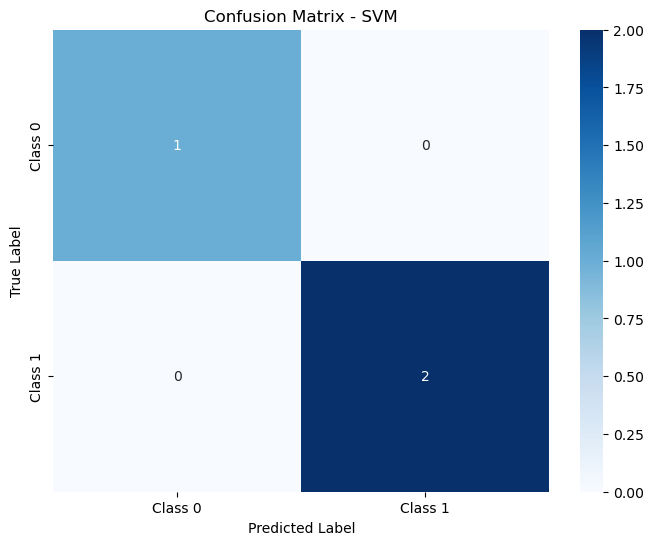

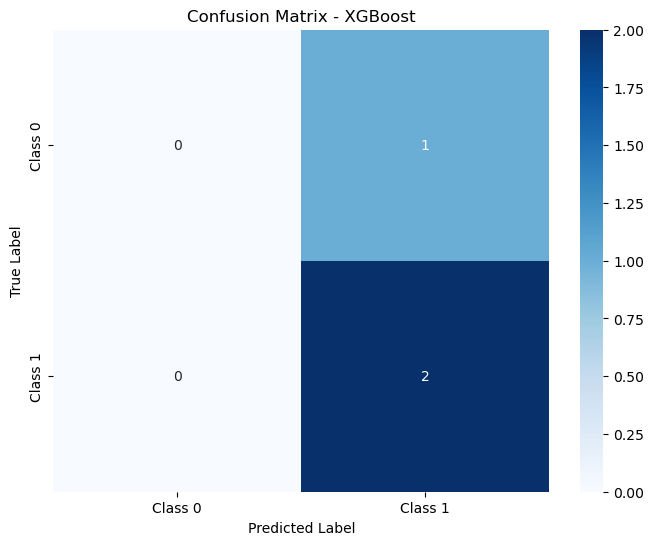

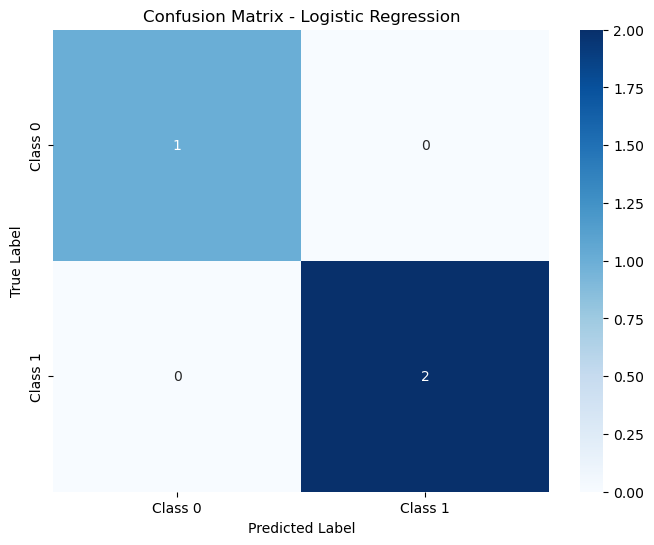

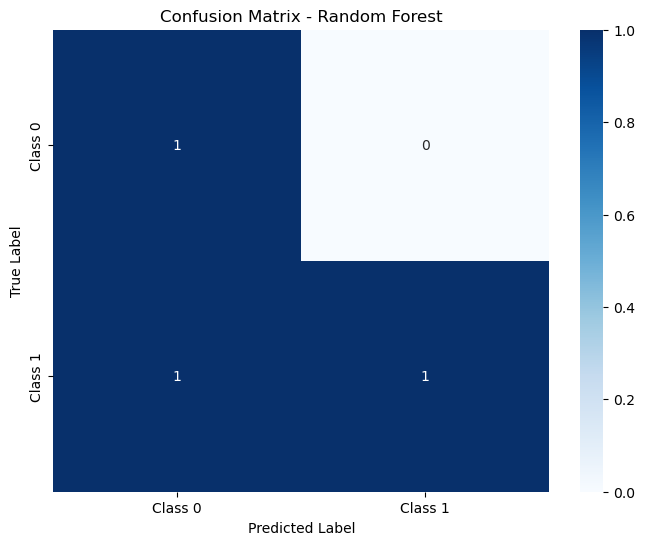

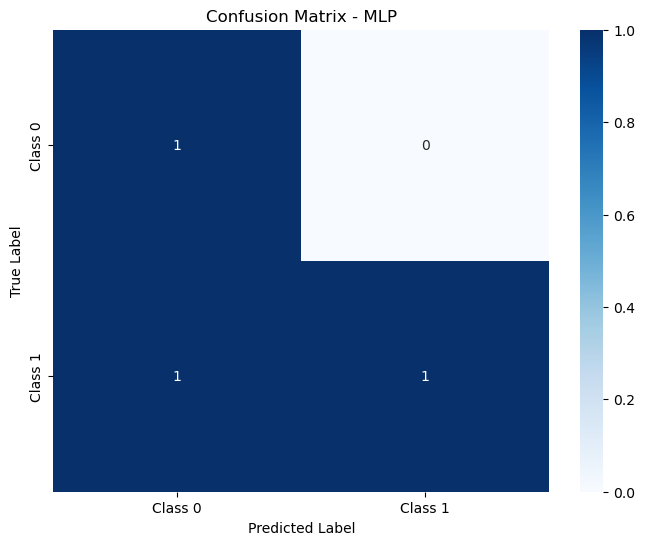


Model performance metrics (Test Set)
                       AUC  Accuracy  Precision  Recall  F1_score
Model                                                            
SVM                 0.0000    1.0000     1.0000  1.0000    1.0000
XGBoost             0.5000    0.6667     0.6667  1.0000    0.8000
Logistic Regression 1.0000    1.0000     1.0000  1.0000    1.0000
Random Forest       1.0000    0.6667     1.0000  0.5000    0.6667
MLP                 1.0000    0.6667     1.0000  0.5000    0.6667

 指标表格已保存到: /home/phl/PHL/Car-T/model_v1/output/model_metrics_summary_test.csv

详细混淆矩阵

SVM:
  TN=1, FP=0
  FN=0, TP=2
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000

XGBoost:
  TN=0, FP=1
  FN=0, TP=2
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 0.0000

Logistic Regression:
  TN=1, FP=0
  FN=0, TP=2
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000

Random Forest:
  TN=1, FP=0
  FN=1, TP=1
  Sensitivity (TPR): 0.5000
  Specificity (TNR): 1.0000

MLP:
  TN=1, FP=0
  FN=1, TP=1

In [13]:
# 计算测试集各类模型评估指标
    
# ========== 计算各模型指标并绘制混淆矩阵 ==========
all_metrics_test = []

# SVM
metrics_test = calculate_metrics(svm, X_test, y_test, label='SVM')
all_metrics_test.append(metrics_test)
plot_confusion_matrix(metrics_test['Confusion_Matrix'], 'SVM', subdir="confusion_matrix_test")

# XGBoost
metrics_test = calculate_metrics(xgb_model, X_test, y_test, label='XGBoost')
all_metrics_test.append(metrics_test)
plot_confusion_matrix(metrics_test['Confusion_Matrix'], 'XGBoost', subdir="confusion_matrix_test")

# LightGBM (如果需要)
# metrics_test = calculate_metrics(lgb_model, X_test, y_test, label='LightGBM', is_lgb=True)
# all_metrics_test.append(metrics_test)
# plot_confusion_matrix(metrics_test['Confusion_Matrix'], 'LightGBM', subdir="confusion_matrix_test")

# Logistic Regression
metrics_test = calculate_metrics(log_reg, X_test, y_test, label='Logistic Regression')
all_metrics_test.append(metrics_test)
plot_confusion_matrix(metrics_test['Confusion_Matrix'], 'Logistic Regression', subdir="confusion_matrix_test")

# Random Forest
metrics_test = calculate_metrics(rf, X_test, y_test, label='Random Forest')
all_metrics_test.append(metrics_test)
plot_confusion_matrix(metrics_test['Confusion_Matrix'], 'Random Forest', subdir="confusion_matrix_test")

# MLP
metrics_test = calculate_metrics(mlp, X_test, y_test, label='MLP')
all_metrics_test.append(metrics_test)
plot_confusion_matrix(metrics_test['Confusion_Matrix'], 'MLP', subdir="confusion_matrix_test")

# ========== 创建汇总表格 ==========
# 提取混淆矩阵之外的所有指标
df_metrics = pd.DataFrame([
    {k: v for k, v in m.items() if k != 'Confusion_Matrix'} 
    for m in all_metrics_test
])

# 设置Model为索引
df_metrics = df_metrics.set_index('Model')

# ========== 美化输出 ==========
print("\n" + "="*80)
print("Model performance metrics (Test Set)")
print("="*80)
print(df_metrics.to_string(float_format=lambda x: f'{x:.4f}'))
print("="*80)

# ========== 保存到CSV ==========
output_csv = "/home/phl/PHL/Car-T/model_v1/output/model_metrics_summary_test.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
df_metrics.to_csv(output_csv)
print(f"\n 指标表格已保存到: {output_csv}")

# ========== 输出详细混淆矩阵 ==========
print("\n" + "="*80)
print("详细混淆矩阵")
print("="*80)
for m in all_metrics_test:
    print(f"\n{m['Model']}:")
    cm = m['Confusion_Matrix']
    print(f"  TN={cm[0,0]}, FP={cm[0,1]}")
    print(f"  FN={cm[1,0]}, TP={cm[1,1]}")
    print(f"  Sensitivity (TPR): {cm[1,1]/(cm[1,0]+cm[1,1]):.4f}")
    print(f"  Specificity (TNR): {cm[0,0]/(cm[0,0]+cm[0,1]):.4f}")
print("="*80)


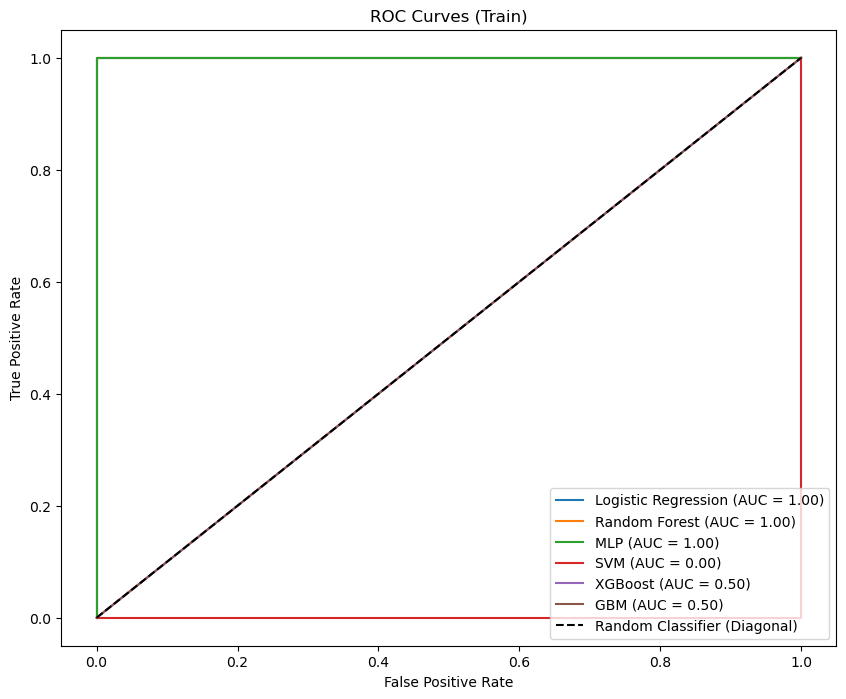

In [14]:
# 计算训练集的ROC曲线和AUC值
def plot_roc_curve(model, X, y, label, is_lgb=False):
    if is_lgb:
        y_pred = model.predict(X, num_iteration=model.best_iteration)
    else:
        y_pred = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    
# 绘制训练集的ROC曲线
plt.figure(figsize=(10, 8))

# 逻辑回归
plot_roc_curve(log_reg, X_train, y_train, 'Logistic Regression')

# 随机森林
plot_roc_curve(rf, X_train, y_train, 'Random Forest')

# 多层感知器 （MLP）
plot_roc_curve(mlp, X_train, y_train, 'MLP')

# SVM
plot_roc_curve(svm, X_train, y_train, 'SVM')

# XGBoost
plot_roc_curve(xgb_model, X_train, y_train, 'XGBoost')

# GBM
plot_roc_curve(lgb_model, X_train, y_train, 'GBM', is_lgb=True)

# 添加对角线（随机分类器的参考线）
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (Diagonal)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Train)')
plt.legend(loc='lower right')
plt.savefig("/home/phl/PHL/Car-T/model_v1/output/roc_curves_train.pdf")
plt.show()

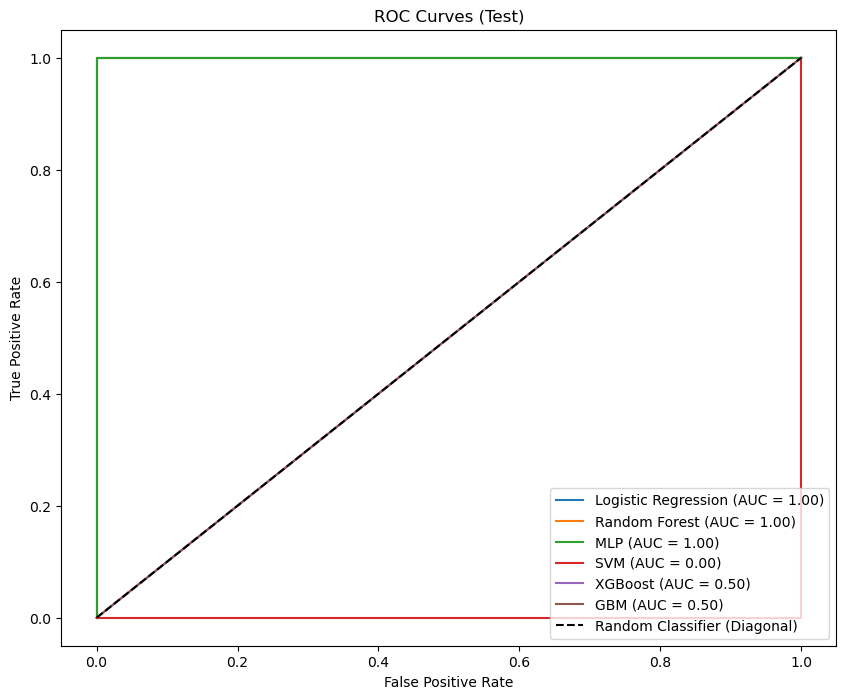

In [15]:
# 绘制测试集的ROC曲线
plt.figure(figsize=(10, 8))
    
# 逻辑回归
plot_roc_curve(log_reg, X_test, y_test, 'Logistic Regression')

# 随机森林
plot_roc_curve(rf, X_test, y_test, 'Random Forest')

# 多层感知器 （MLP）
plot_roc_curve(mlp, X_test, y_test, 'MLP')

# SVM
plot_roc_curve(svm, X_test, y_test, 'SVM')

# XGBoost
plot_roc_curve(xgb_model, X_test, y_test, 'XGBoost')

# GBM
plot_roc_curve(lgb_model, X_test, y_test, 'GBM', is_lgb=True)

# 添加对角线（随机分类器的参考线）
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (Diagonal)')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Test)')
plt.legend(loc='lower right')
plt.savefig("/home/phl/PHL/Car-T/model_v1/output/roc_curves_test.pdf")
plt.show()

                 Model  AUC Score  CI Lower Bound  CI Upper Bound
0                  SVM        0.0       -0.241136        0.241136
1              XGBoost        0.5        0.500000        0.500000
2                  GBM        0.5        0.500000        0.500000
3  Logistic Regression        1.0        0.802850        1.197150
4        Random Forest        1.0        0.820363        1.179637
5                  MLP        1.0        0.696001        1.303999


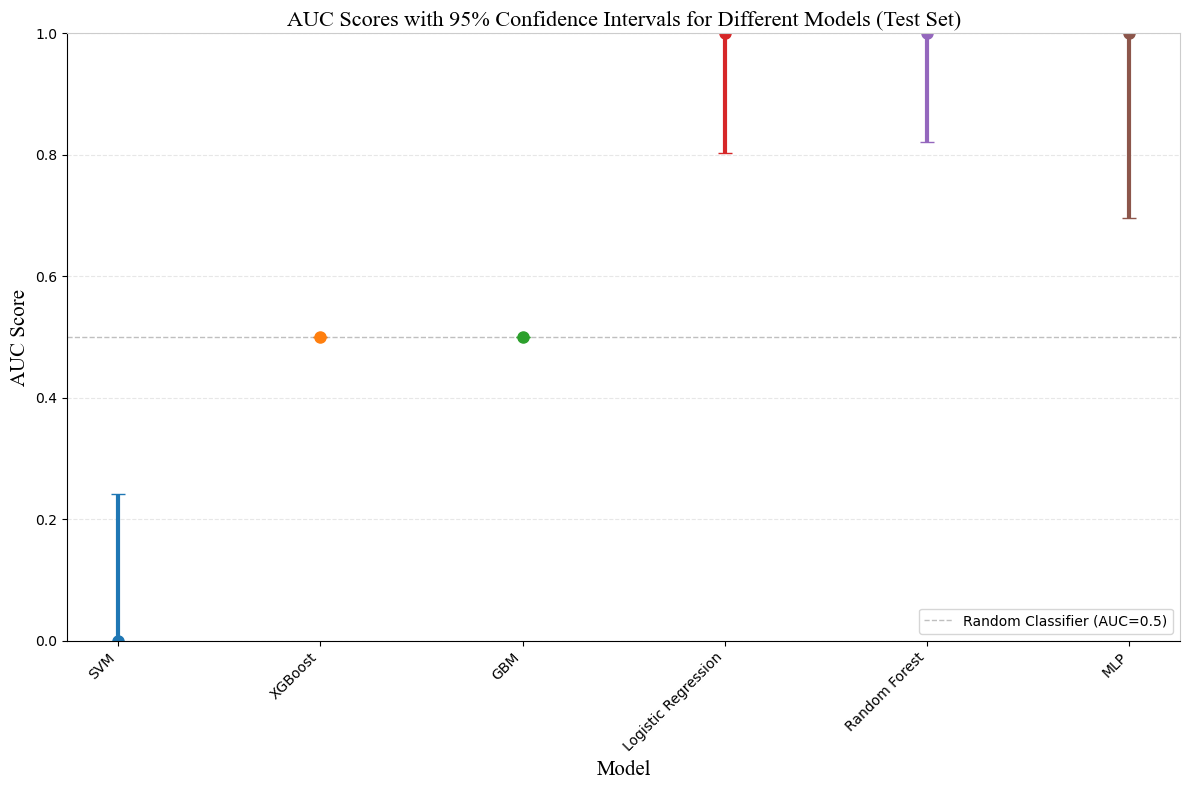


========== 模型性能统计摘要 ==========
SVM                  | AUC: 0.0000 | 95% CI: [-0.2411, 0.2411]
XGBoost              | AUC: 0.5000 | 95% CI: [0.5000, 0.5000]
GBM                  | AUC: 0.5000 | 95% CI: [0.5000, 0.5000]
Logistic Regression  | AUC: 1.0000 | 95% CI: [0.8029, 1.1971]
Random Forest        | AUC: 1.0000 | 95% CI: [0.8204, 1.1796]
MLP                  | AUC: 1.0000 | 95% CI: [0.6960, 1.3040]


In [16]:
#### 绘制测试集数据类森林图
from scipy.stats import sem
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# 计算 AUC 及其置信区间的函数
def compute_confidence_interval(data, confidence=0.95):
    n = len(data)         # 数据样本数
    mean = np.mean(data)  # 计算均值
    std_err = sem(data)   # 计算标准误差
    h= std_err * 1.96      # 对于95%的置信区间
    return mean,mean -h, mean + h

# 定义模型字典
models ={
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model,
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp
}

# 计算每个模型的 AUC 及其置信区间
results = []
for name,model in models.items():
    if name =='XGBoost':
        y_pred = model.predict_proba(X_test)[:, 1] # 使用验证集数据
    elif name =='GBM':
        y_pred = model.predict(X_test) # 对GBM模型直接使用predict方法
    else:
        y_pred = model.predict_proba(X_test)[:, 1]
        
    auc_score = roc_auc_score(y_test, y_pred) # 计算AUC得分
    auc_std = sem(y_pred) # 计算AUC的标准误差
    ci = 1.96 * auc_std # 95% 置信区间
    results.append((name, auc_score, auc_score - ci, auc_score + ci)) # 添加结果到结果列表
        
        
# 创建 DataFrame 并展示 AUC 数据
df_results = pd.DataFrame(results, columns=['Model', 'AUC Score', 'CI Lower Bound', 'CI Upper Bound'])
print(df_results)

# 可选：保存为CSV 文件
df_results.to_csv('/home/phl/PHL/Car-T/model_v1/output//auc_results_test.csv', index=False)


# ========== 绘制森林图（纵向布局）==========
# 提取数据用于绘图
names = df_results['Model'].tolist()
means = df_results['AUC Score'].tolist()
lower_bounds = df_results['CI Lower Bound'].tolist()
upper_bounds = df_results['CI Upper Bound'].tolist()

# 定义颜色（为每个模型分配不同颜色）
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# 创建图形
fig, ax = plt.subplots(figsize=(12, 8))

# 绘制纵向误差条（森林图 - 纵向布局）
for i, (mean, lower, upper, color) in enumerate(zip(means, lower_bounds, upper_bounds, colors)):
    # 计算误差条的长度
    yerr_lower = mean - lower
    yerr_upper = upper - mean
    
    # 绘制误差条（注意：这里交换了x和y的位置）
    ax.errorbar(
        i,              # x位置：模型索引
        mean,           # y位置：AUC均值
        yerr=[[yerr_lower], [yerr_upper]],  # 误差范围（现在是纵向的）
        fmt='o',        # 点的样式
        color=color,    # 颜色
        ecolor=color,   # 误差条颜色
        elinewidth=3,   # 误差条线宽
        capsize=5,      # 误差条端点长度
        markersize=8    # 点的大小
    )

# 添加参考线（AUC = 0.5，随机分类器）- 现在是水平线
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Random Classifier (AUC=0.5)')

# 设置图形参数（X轴和Y轴互换）
ax.set_xticks(range(len(names)))  # 设置x轴刻度
ax.set_xticklabels(names, rotation=45, ha='right')  # 设置x轴标签，旋转45度便于阅读
ax.set_ylim(0, 1.0)  # 设置Y轴范围
ax.set_xlabel('Model', fontdict={'family': 'Times New Roman', 'fontsize': 15})  # X轴标签
ax.set_ylabel('AUC Score', fontdict={'family': 'Times New Roman', 'fontsize': 15})  # Y轴标签
ax.set_title('AUC Scores with 95% Confidence Intervals for Different Models (Test Set)', 
             fontdict={'family': 'Times New Roman', 'fontsize': 16})  # 设置图表标题

# 添加网格（现在是水平网格线）
ax.grid(axis='y', alpha=0.3, linestyle='--')

# 美化边框
ax.spines['right'].set_color((0.8, 0.8, 0.8))
ax.spines['top'].set_color((0.8, 0.8, 0.8))

# 添加图例
ax.legend(loc='lower right')

# 调整布局
plt.tight_layout()

# 保存图表为PDF文件
plt.savefig('/home/phl/PHL/Car-T/model_v1/output/forestplot_test.pdf', bbox_inches='tight', dpi=300)
plt.show()  # 显示图表

# 打印统计摘要
print("\n========== 模型性能统计摘要 ==========")
for i, row in df_results.iterrows():
    print(f"{row['Model']:20s} | AUC: {row['AUC Score']:.4f} | 95% CI: [{row['CI Lower Bound']:.4f}, {row['CI Upper Bound']:.4f}]")



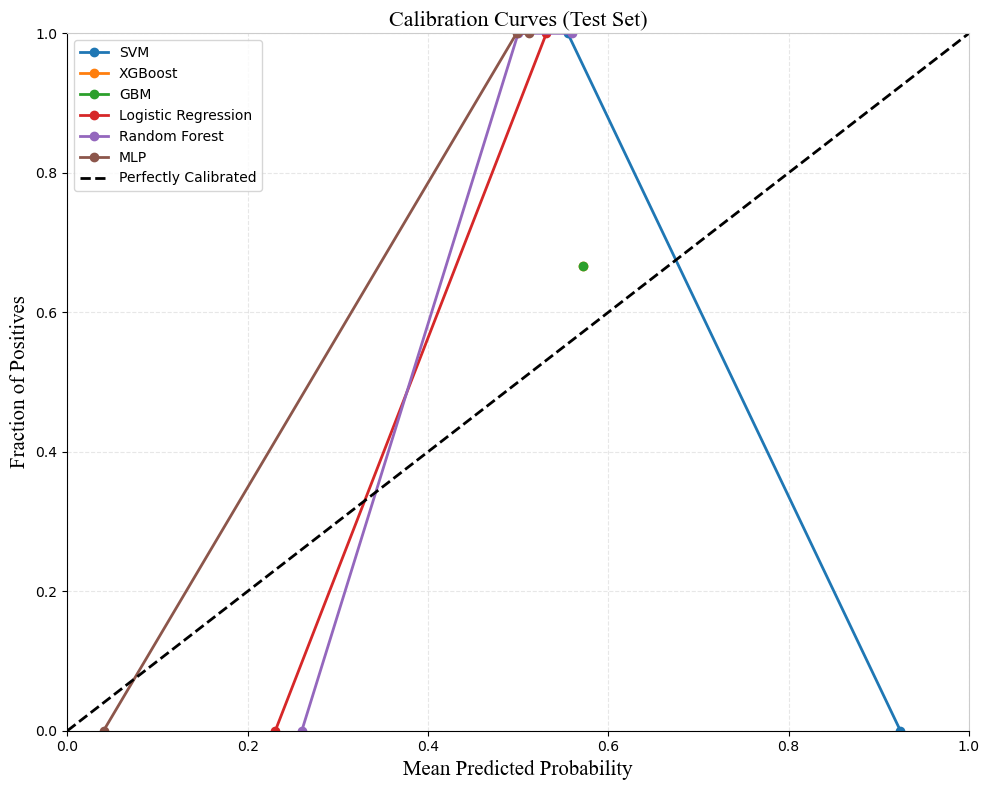


========== 校准曲线统计信息 ==========
SVM                  | 平均校准误差: 0.6845
XGBoost              | 平均校准误差: 0.0952
GBM                  | 平均校准误差: 0.0952
Logistic Regression  | 平均校准误差: 0.3497
Random Forest        | 平均校准误差: 0.4000
MLP                  | 平均校准误差: 0.3432


In [17]:
#### 绘制测试集校准曲线
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# 计算每个模型的预测概率的函数
def get_predictions(model, X, model_name):
    if model_name == 'GBM':
        return model.predict(X)  # 对GBM模型使用predict方法
    else:
        return model.predict_proba(X)[:, 1]  # 其他模型使用predict_proba方法并选择概率列

# 创建图形
fig, ax = plt.subplots(figsize=(10, 8))
# plt.figure(figsize=(10, 8))

# 定义颜色
colors = {'SVM': '#1f77b4', 'XGBoost': '#ff7f0e', 'GBM': '#2ca02c', 
          'Logistic Regression': '#d62728', 'Random Forest': '#9467bd', 'MLP': '#8c564b'}

# 遍历每个模型并绘制校准曲线
for name, model in models.items():
    y_pred = get_predictions(model, X_test, name) # 获取模型的预测概率
    y_pred = np.clip(y_pred, 0, 1) # 将预测值限制在［0，1］范围内

#     # 进行Isotonic Regression校准
#     iso_reg = IsotonicRegression(out_of_bounds='clip')
#     y_pred_calibrated = iso_reg.fit_transform(y_pred, y_test) # 使用Isotonic Regression 进行校准

    # 原始模型的校准曲线
    # 计算校准曲线
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10, strategy='uniform')
    
    # 绘制校准曲线
    ax.plot(prob_pred, prob_true, marker='o', linewidth=2, 
            label=name, color=colors.get(name, 'gray'))

# 绘制完美校准线（对角线）
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfectly Calibrated')

# 设置图形参数
ax.set_xlabel('Mean Predicted Probability', fontdict={'family': 'Times New Roman', 'fontsize': 15})
ax.set_ylabel('Fraction of Positives', fontdict={'family': 'Times New Roman', 'fontsize': 15})
ax.set_title('Calibration Curves (Test Set)', fontdict={'family': 'Times New Roman', 'fontsize': 16})

# 设置坐标轴范围
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# 添加网格
ax.grid(alpha=0.3, linestyle='--')

# 美化边框
ax.spines['right'].set_color((0.8, 0.8, 0.8))
ax.spines['top'].set_color((0.8, 0.8, 0.8))

# 添加图例
ax.legend(loc='upper left', fontsize=10)

# 调整布局
plt.tight_layout()

# 保存图形
plt.savefig('/home/phl/PHL/Car-T/model_v1/output/calibration_curves_test.pdf', 
            bbox_inches='tight', dpi=300)
plt.show()

# 可选：打印每个模型的校准统计信息
print("\n========== 校准曲线统计信息 ==========")
for name, model in models.items():
    y_pred = get_predictions(model, X_test, name)
    y_pred = np.clip(y_pred, 0, 1)
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
    
    # 计算校准误差（Calibration Error）
    calibration_error = np.mean(np.abs(prob_true - prob_pred))
    print(f"{name:20s} | 平均校准误差: {calibration_error:.4f}")

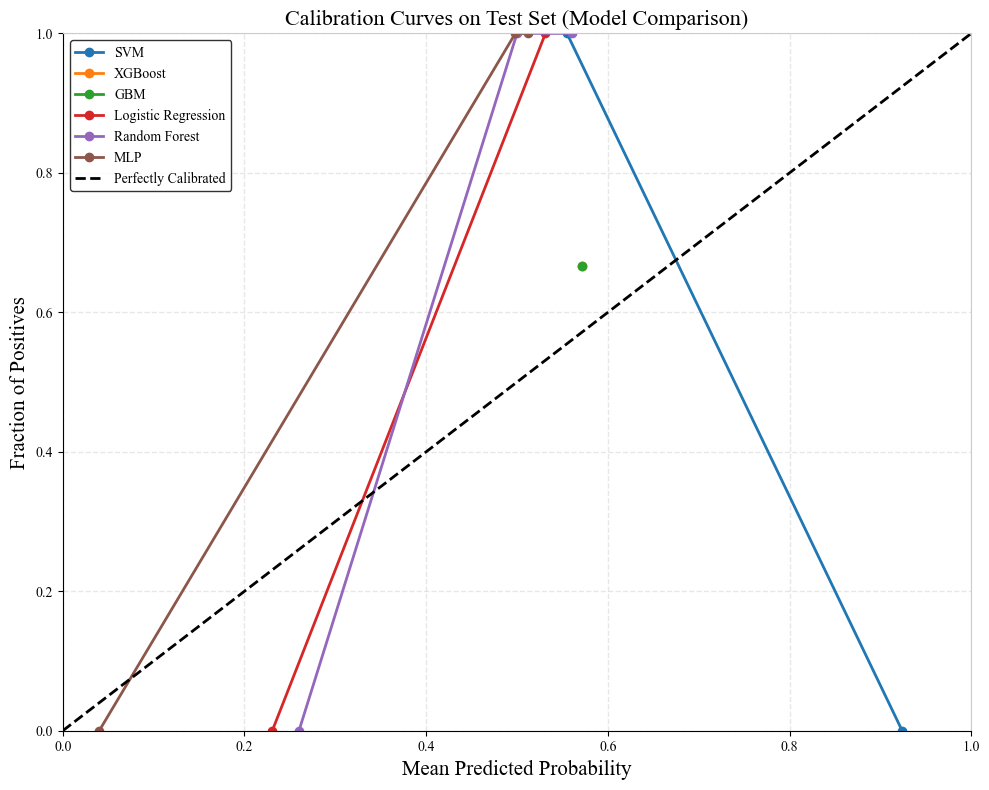

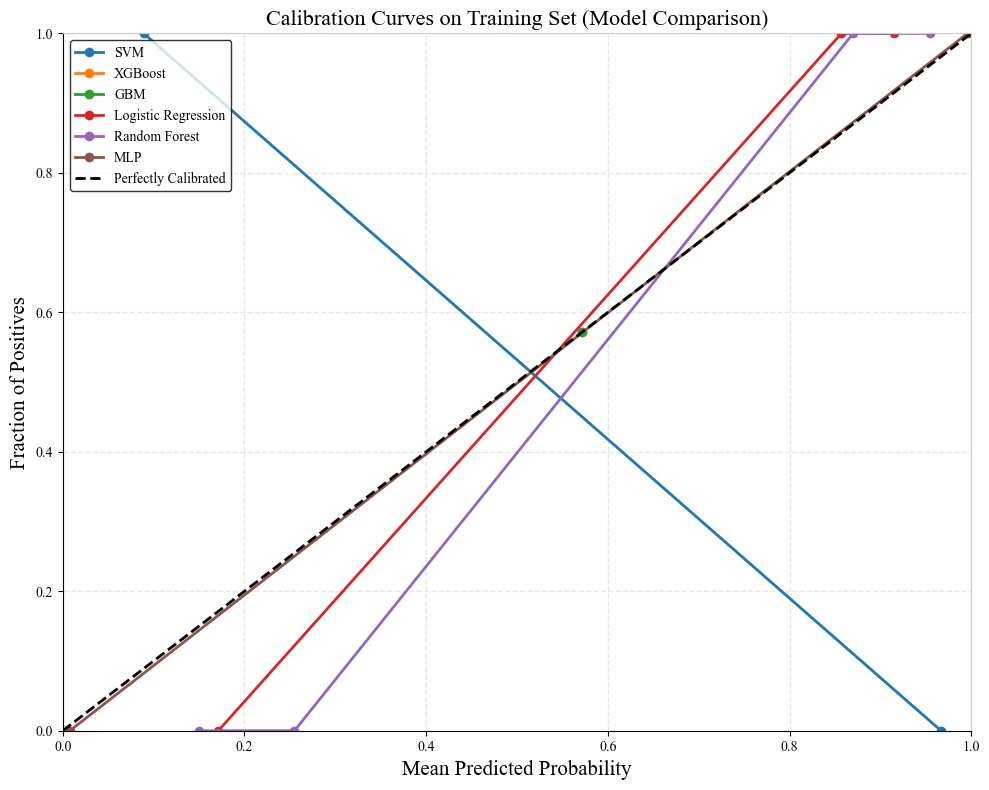

In [18]:
# 单元格16的修复版本（建议直接删除，使用单元格15）

# =========================================================================================
# ====================================== 1. 库的导入 =========================================
# =========================================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# =========================================================================================
# ====================================== 2. 绘图函数（完整版）=====================================
# =========================================================================================
def plot_calibration_curves(y_true, all_scores, plot_title, n_bins=10, filename=None):
    """
    绘制校准曲线
    
    参数:
        y_true: 真实标签
        all_scores: 字典，格式为 {模型名: 预测概率数组}
        plot_title: 图表标题
        n_bins: 分箱数量
        filename: 保存文件名（可选）
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor('white')  # 背景颜色
    
    # 定义颜色
    colors = {'SVM': '#1f77b4', 'XGBoost': '#ff7f0e', 'GBM': '#2ca02c', 
              'Logistic Regression': '#d62728', 'Random Forest': '#9467bd', 'MLP': '#8c564b'}
    
    # 遍历所有模型并绘制校准曲线
    for model_name, y_scores in all_scores.items():
        y_scores_clipped = np.clip(y_scores, 0, 1)
        prob_true, prob_pred = calibration_curve(y_true, y_scores_clipped, 
                                                  n_bins=n_bins, strategy='uniform')
        
        ax.plot(prob_pred, prob_true, marker='o', linewidth=2, 
                label=model_name, color=colors.get(model_name, 'gray'))
    
    # 绘制对角虚线/参考线
    ax.plot([0, 1], [0, 1], 'k--', lw=2, linestyle='--', label='Perfectly Calibrated')
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=15, 
                  fontdict={'family': 'Times New Roman'})
    ax.set_ylabel('Fraction of Positives', fontsize=15, 
                  fontdict={'family': 'Times New Roman'})
    ax.set_title(plot_title, fontsize=16, fontdict={'family': 'Times New Roman'})
    
    # 添加网格
    ax.grid(True, linestyle='--', linewidth=1, alpha=0.3)
    
    # 添加图例
    ax.legend(loc='upper left', fontsize=10, frameon=True, edgecolor='black')
    
    # 美化边框
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    
    plt.tight_layout()
    
    # 保存图形
    if filename:
        plt.savefig(f'/home/phl/PHL/Car-T/model_v1/output/{filename}.pdf', 
                    bbox_inches='tight', dpi=300)
    
    plt.show()


# =========================================================================================
# ====================================== 3. 使用您的实际数据绘制校准曲线 ======================
# =========================================================================================

# 定义获取预测概率的函数
def get_predictions(model, X, model_name):
    if model_name == 'GBM':
        return model.predict(X)
    else:
        return model.predict_proba(X)[:, 1]

# 收集所有模型在测试集上的预测分数
test_scores_dict = {}
for name, model in models.items():
    test_scores_dict[name] = get_predictions(model, X_test, name)

# 绘制测试集的校准曲线
plot_calibration_curves(
    y_test,
    test_scores_dict,
    "Calibration Curves on Test Set (Model Comparison)",
    n_bins=10,
    filename='calibration_curves_test_v2'
)

# 可选：同样绘制训练集的校准曲线
train_scores_dict = {}
for name, model in models.items():
    train_scores_dict[name] = get_predictions(model, X_train, name)

plot_calibration_curves(
    y_train,
    train_scores_dict,
    "Calibration Curves on Training Set (Model Comparison)",
    n_bins=10,
    filename='calibration_curves_train_v2'
)

### lgb的模型名称为lgb_model，且lgb只能用predict函数，而不是predict_proba函数
gbm_preds_test = lgb_model.predict(X_test)   # GBM模型不需要[:, 1]

- 如果 is_lgb=True，它调用 model.predict()（因为 LightGBM 原生 Booster 对象直接输出概率）。
- 如果 is_lgb=False，它调用 model.predict_proba()[:, 1]（这是 Scikit-learn 标准模型的用法）。

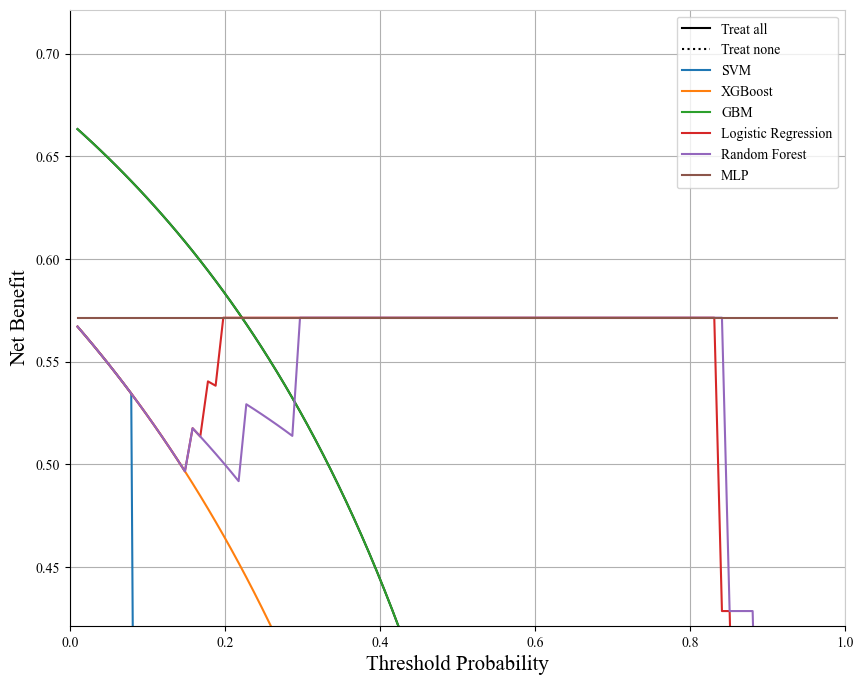

In [19]:
#### 绘制训练集的DCA曲线
from sklearn.metrics import roc_curve,auc,confusion_matrix

# 计算模型的净收益的函数
def calculate_net_benefit_model(thresh_group,y_pred_score,y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score >thresh #根据阈值分类
        tn,fp,fn,tp = confusion_matrix(y_label, y_pred_label).ravel() # 计算混淆矩障的四个值
        n = len(y_label)
        net_benefit = (tp / n)- (fp / n)*(thresh / (1 - thresh)) # 计算净收益
        net_benefit_model = np.append(net_benefit_model,net_benefit)# 将净收益添加到数组
    return net_benefit_model
    
# 计算所有样本净收益的函数
def calculate_net_benefit_all(thresh_group,y_label):
    net_benefit_all = np.array([])
    tn, fp,fn,tp = confusion_matrix(y_label,y_label).ravel() # 计算混淆矩阵的四个值（所有样本）
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total)- (tn / total)*(thresh /(1 -thresh)) # 计算净收益
        net_benefit_all = np.append(net_benefit_all, net_benefit)# 将净收益添加到数组
    return net_benefit_all

# 绘制决策曲线分析（DCA）图的函数
def plot_DCA(ax,thresh_group,net_benefit_model,label):
    # 绘制净收益曲线
    ax.plot(thresh_group,net_benefit_model, label=f'{label}')

    # 设置图形参数
    ax.set_xlim(0, 1)  # 设置X轴范围
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)  # 设置Y轴范围
    ax.set_xlabel('Threshold Probability', fontdict={'family': 'Times New Roman', 'fontsize': 15})
    ax.set_ylabel('Net Benefit', fontdict={'family': 'Times New Roman', 'fontsize': 15})
    ax.grid('major')  # 在图形设置中启用网格，只需删除 ax.grid('major') 行
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc='upper right')  # 显示图例
    
    return ax

# 绘制测试集的DCA曲线
fig,ax = plt.subplots(figsize=(10, 8))

# 定义阈值组
thresh_group = np.linspace(0.01, 0.99, 100)

# 计算net_benefit_all
net_benefit_all = calculate_net_benefit_all(thresh_group, y_test)

# 绘制 “Treat all" 和 “Treat none”
ax.plot(thresh_group,net_benefit_all, color="black",label='Treat all')
ax.plot ([0,1],[0,0],color='black',linestyle=":",label='Treat none')

# 填充 Treat all 和 Treat none 之间的区域
y2 = np.maximum(net_benefit_all, 0)
y1 = np.maximum(0, y2)
ax.fill_between(thresh_group, y1, y2, alpha=0.2)

# SVM模型
svm_preds_train = svm.predict_proba(X_train)[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group, svm_preds_train, y_train)
ax = plot_DCA(ax, thresh_group, net_benefit_model, 'SVM')

# XGBoost模型
xgb_preds_train = xgb_model.predict_proba(X_train)[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group,xgb_preds_train,y_train)
ax = plot_DCA(ax, thresh_group, net_benefit_model, 'XGBoost')

# GBM模型
gbm_preds_test = lgb_model.predict(X_test)   # GBM模型不需要[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group,gbm_preds_test,y_test)
ax = plot_DCA(ax,thresh_group,net_benefit_model,'GBM')  


# 逻辑回归模型
log_reg_preds_train = log_reg.predict_proba(X_train)[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group,log_reg_preds_train, y_train)
ax = plot_DCA(ax,thresh_group,net_benefit_model,'Logistic Regression')

# 随机森林模型
rf_preds_train = rf.predict_proba(X_train)[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group,rf_preds_train,y_train)
ax = plot_DCA(ax, thresh_group,net_benefit_model,'Random Forest')

# MLP模型
mlp_preds_train = mlp.predict_proba(X_train)[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group,mlp_preds_train,y_train)
ax = plot_DCA(ax,thresh_group,net_benefit_model,'MLP')

# 最后保存图像并显示
plt.savefig("/home/phl/PHL/Car-T/model_v1/output/dca_curves_train.pdf")# 保存DCA图像为PDF文件
plt.show() # 显示DCA图像

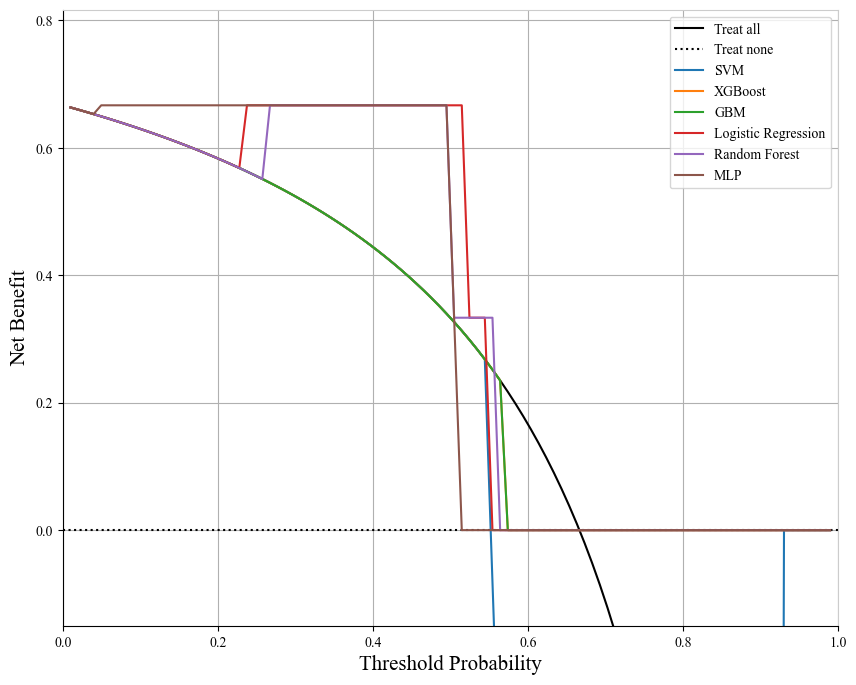

In [20]:
### 绘制测试集的DCA曲线
from sklearn.metrics import roc_curve,auc,confusion_matrix

# 计算模型的净收益的函数
def calculate_net_benefit_model(thresh_group,y_pred_score,y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score >thresh #根据阈值分类
        tn,fp,fn,tp = confusion_matrix(y_label, y_pred_label).ravel() # 计算混淆矩障的四个值
        n = len(y_label)
        net_benefit = (tp / n)- (fp / n)*(thresh / (1 - thresh)) # 计算净收益
        net_benefit_model = np.append(net_benefit_model,net_benefit)# 将净收益添加到数组
    return net_benefit_model
    
# 计算所有样本净收益的函数
def calculate_net_benefit_all(thresh_group,y_label):
    net_benefit_all = np.array([])
    tn, fp,fn,tp = confusion_matrix(y_label,y_label).ravel() # 计算混淆矩阵的四个值（所有样本）
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total)- (tn / total)*(thresh /(1 -thresh)) # 计算净收益
        net_benefit_all = np.append(net_benefit_all, net_benefit)# 将净收益添加到数组
    return net_benefit_all

# 绘制决策曲线分析（DCA）图的函数
def plot_DCA(ax,thresh_group,net_benefit_model,label):
    # 绘制净收益曲线
    ax.plot(thresh_group,net_benefit_model, label=f'{label}')

    # 设置图形参数
    ax.set_xlim(0, 1)  # 设置X轴范围
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)  # 设置Y轴范围
    ax.set_xlabel('Threshold Probability', fontdict={'family': 'Times New Roman', 'fontsize': 15})
    ax.set_ylabel('Net Benefit', fontdict={'family': 'Times New Roman', 'fontsize': 15})
    ax.grid('major')  # 在图形设置中启用网格，只需删除 ax.grid('major') 行
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc='upper right')  # 显示图例
    
    return ax

# 绘制测试集的DCA曲线
fig,ax = plt.subplots(figsize=(10, 8))

# 定义阈值组
thresh_group = np.linspace(0.01, 0.99, 100)

# 计算net_benefit_all
net_benefit_all = calculate_net_benefit_all(thresh_group, y_test)

# 绘制 “Treat all" 和 “Treat none”
ax.plot(thresh_group,net_benefit_all, color="black",label='Treat all')
ax.plot ([0,1],[0,0],color='black',linestyle=":",label='Treat none')

# 填充 Treat all 和 Treat none 之间的区域
y2 = np.maximum(net_benefit_all, 0)
y1 = np.maximum(0, y2)
ax.fill_between(thresh_group, y1, y2, alpha=0.2)

# SVM模型
svm_preds_test = svm.predict_proba(X_test)[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group, svm_preds_test, y_test)
ax = plot_DCA(ax, thresh_group, net_benefit_model, 'SVM')

# XGBoost模型
xgb_preds_test = xgb_model.predict_proba(X_test)[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group,xgb_preds_test,y_test)
ax = plot_DCA(ax, thresh_group, net_benefit_model, 'XGBoost')

# GBM模型
gbm_preds_test = lgb_model.predict(X_test)   # GBM模型不需要[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group,gbm_preds_test,y_test)
ax = plot_DCA(ax,thresh_group,net_benefit_model,'GBM')  


# 逻辑回归模型
log_reg_preds_test = log_reg.predict_proba(X_test)[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group,log_reg_preds_test, y_test)
ax = plot_DCA(ax,thresh_group,net_benefit_model,'Logistic Regression')

# 随机森林模型
rf_preds_test = rf.predict_proba(X_test)[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group,rf_preds_test,y_test)
ax = plot_DCA(ax, thresh_group,net_benefit_model,'Random Forest')

# MLP模型
mlp_preds_test = mlp.predict_proba(X_test)[:, 1]
net_benefit_model = calculate_net_benefit_model(thresh_group,mlp_preds_test,y_test)
ax = plot_DCA(ax,thresh_group,net_benefit_model,'MLP')

# 最后保存图像并显示
plt.savefig("/home/phl/PHL/Car-T/model_v1/output/dca_curves_test.pdf")# 保存DCA图像为PDF文件
plt.show() # 显示DCA图像

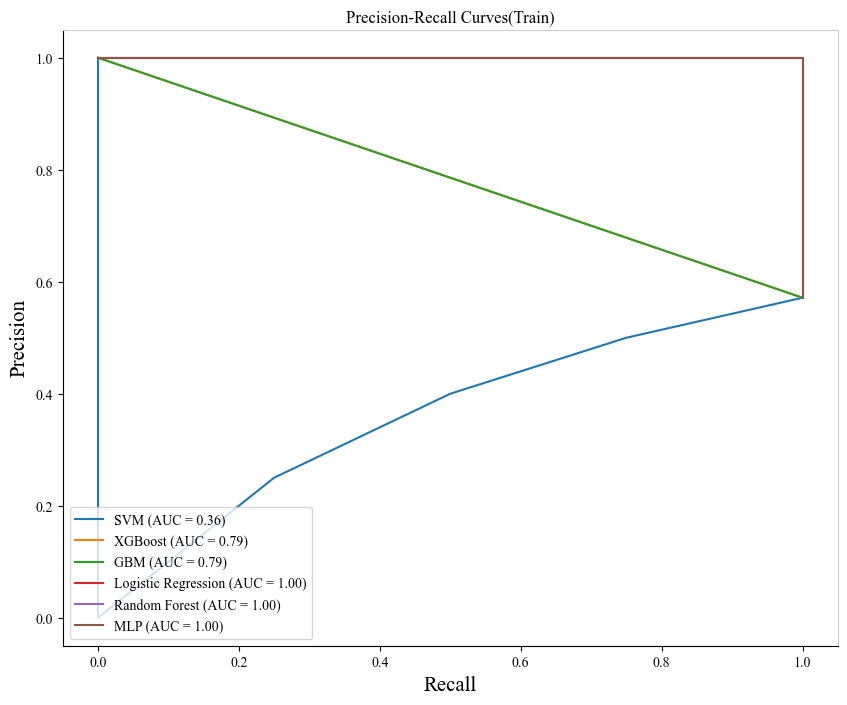

In [21]:
#### 训练集的PR曲线
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(ax, y_true, y_scores,label):
    """绘制PR曲线"""
    # 计算Precision-Recall曲线
    precision,recall,thresholds = precision_recall_curve(y_true, y_scores)
    # 计算AUC值
    auc_score = auc(recall, precision)

    # 绘制PR曲线
    ax.plot(recall,precision, label=f'{label} (AUC = {auc_score:.2f})')

    # 图表配置
    ax.set_xlabel("Recall", fontdict={'family': 'Times New Roman', 'fontsize': 15})
    ax.set_ylabel("Precision", fontdict={'family': 'Times New Roman', 'fontsize': 15})
    ax.spines['right'].set_color((0.8, 0.8, 0.8)) #设置右边框的颜色
    ax.spines['top'].set_color((0.8, 0.8, 0.8)) #设置上边框的颜色
    ax.legend(loc='lower left') # 设置图例位置

    return ax

# 绘制训练集的PR曲线
fig_train, ax_train = plt.subplots(figsize=(10, 8))

# SVM模型
svm_preds_train = svm.predict_proba(X_train)[:, 1]
ax_train = plot_pr_curve(ax_train,y_train, svm_preds_train, 'SVM')

# XGBoost模型
xgb_preds_train = xgb_model.predict_proba(X_train)[:, 1]
ax_train = plot_pr_curve(ax_train,y_train, xgb_preds_train, 'XGBoost')

# GBM模型
gbm_preds_train = lgb_model.predict(X_train)
ax_train = plot_pr_curve(ax_train, y_train, gbm_preds_train, 'GBM')

# 逻辑回归模型
log_reg_preds_train = log_reg.predict_proba(X_train)[:, 1]
ax_train = plot_pr_curve(ax_train, y_train, log_reg_preds_train, 'Logistic Regression')

# 随机森林模型
rf_preds_train = rf.predict_proba(X_train)[:, 1]
ax_train = plot_pr_curve(ax_train, y_train, rf_preds_train, 'Random Forest')

# MLP模型
mlp_preds_train = mlp.predict_proba(X_train)[:, 1]
ax_train = plot_pr_curve(ax_train,y_train,mlp_preds_train,'MLP')

# 设置图标题并保存训练集PR曲线图像
plt.title('Precision-Recall Curves(Train)')
plt.savefig("/home/phl/PHL/Car-T/model_v1/output/pr_curves_train.pdf")
plt.show()

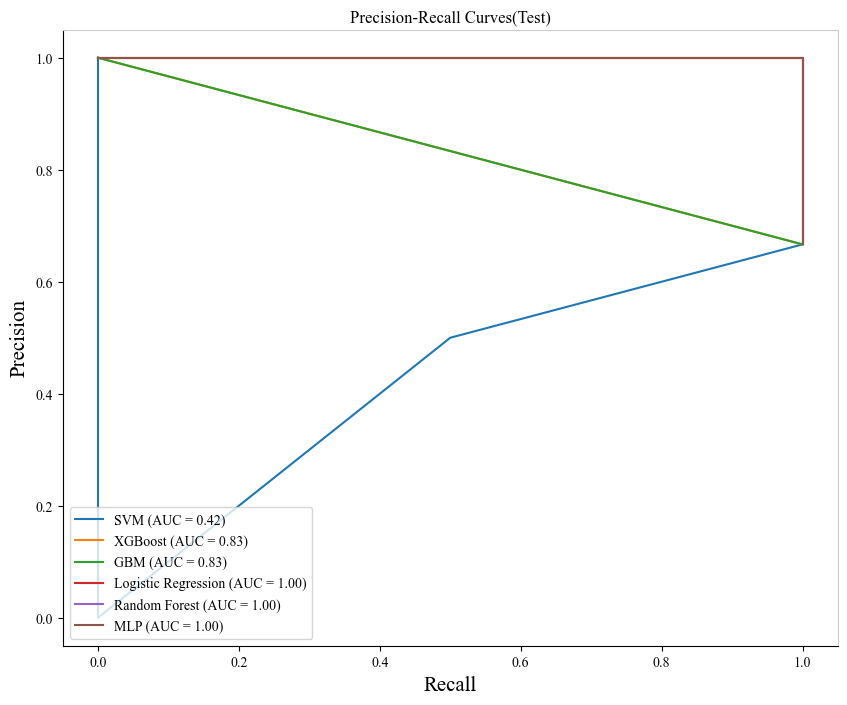

In [22]:
#### 测试集的PR曲线
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(ax, y_true, y_scores,label):
    """绘制PR曲线"""
    # 计算Precision-Recall曲线
    precision,recall,thresholds = precision_recall_curve(y_true, y_scores)
    # 计算AUC值
    auc_score = auc(recall, precision)

    # 绘制PR曲线
    ax.plot(recall,precision, label=f'{label} (AUC = {auc_score:.2f})')

    # 图表配置
    ax.set_xlabel("Recall", fontdict={'family': 'Times New Roman', 'fontsize': 15})
    ax.set_ylabel("Precision", fontdict={'family': 'Times New Roman', 'fontsize': 15})
    ax.spines['right'].set_color((0.8, 0.8, 0.8)) #设置右边框的颜色
    ax.spines['top'].set_color((0.8, 0.8, 0.8)) #设置上边框的颜色
    ax.legend(loc='lower left') # 设置图例位置

    return ax

#### 绘制测试集的PR曲线
fig_test, ax_test = plt.subplots(figsize=(10, 8))

# SVM模型
svm_preds_test = svm.predict_proba(X_test)[:, 1]
ax_test = plot_pr_curve(ax_test,y_test, svm_preds_test, 'SVM')

# XGBoost模型
xgb_preds_test = xgb_model.predict_proba(X_test)[:, 1]
ax_test = plot_pr_curve(ax_test,y_test, xgb_preds_test, 'XGBoost')

# GBM模型
gbm_preds_test = lgb_model.predict(X_test)
ax_test = plot_pr_curve(ax_test, y_test, gbm_preds_test, 'GBM')

# 逻辑回归模型
log_reg_preds_test = log_reg.predict_proba(X_test)[:, 1]
ax_test = plot_pr_curve(ax_test, y_test, log_reg_preds_test, 'Logistic Regression')

# 随机森林模型
rf_preds_test = rf.predict_proba(X_test)[:, 1]
ax_test = plot_pr_curve(ax_test, y_test, rf_preds_test, 'Random Forest')

# MLP模型
mlp_preds_test = mlp.predict_proba(X_test)[:, 1]
ax_test = plot_pr_curve(ax_test,y_test,mlp_preds_test,'MLP')

# 设置图标题并保存测试集PR曲线图像
plt.title('Precision-Recall Curves(Test)')
plt.savefig("/home/phl/PHL/Car-T/model_v1/output/pr_curves_test.pdf")
plt.show()

## 最优模型MLP

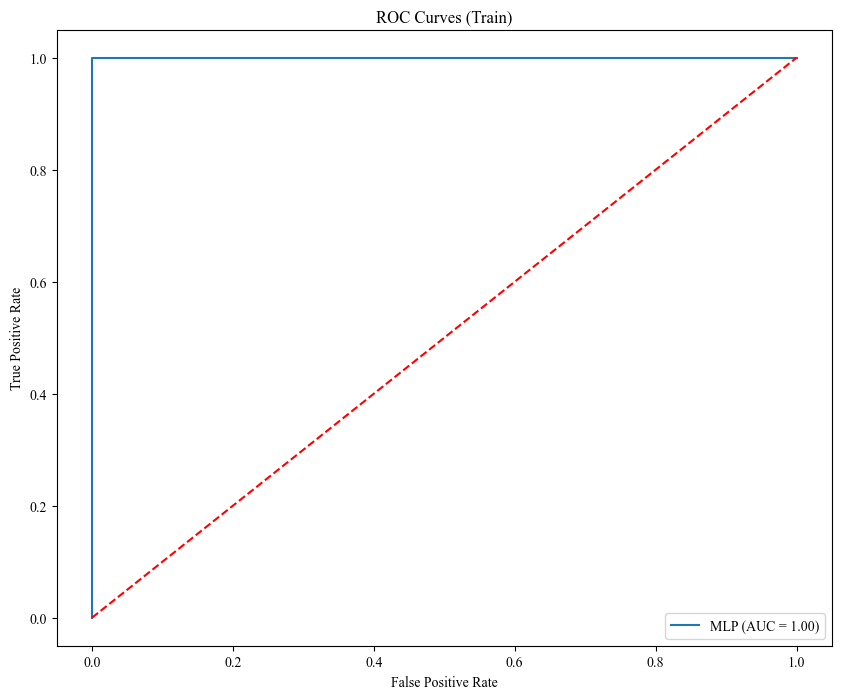

In [23]:
# 训练集
plt.figure(figsize=(10,8))
plot_roc_curve(mlp, X_train, y_train, 'MLP')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Train)')
plt.legend(loc='lower right')
plt.savefig("/home/phl/PHL/Car-T/model_v1/output/bestmodel_roc_curves_train.pdf")
plt.show()